In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


## Convert image to patches 

- **Input Shape:** `(B, 3, 32, 32)`  
- **After Unfolding:** `(B, 48, 64)`  
  - Each patch has `3 × 4 × 4 = 48` values, with 64 patches.  
- **After Transposing:** `(B, 64, 48)`  
  - Rearranges the tensor so each patch is a separate sequence element.  
- **After Linear Projection:** `(B, 64, 64)`  
  - A linear layer projects each 48-dimensional patch to 64 dimensions.


In [4]:
class PatchEmbed(nn.Module):
    
    def __init__(self, img_size=32, patch_size=4, stride=None, in_chans=3, embed_dim=64):
        super(PatchEmbed, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        
        self.stride = stride if stride is not None else patch_size                 # Use non-overlapping patches if stride is not specified.
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        self.num_patches_x = (img_size - patch_size) // self.stride + 1              # Calculate number of patches per side and total patches
        self.num_patches = self.num_patches_x * self.num_patches_x
        
        self.proj = nn.Linear(in_chans * patch_size * patch_size, embed_dim)
        
    def forward(self, x):
        """
        x: (B, C, H, W)
        Returns: (B, num_patches, embed_dim)
        """
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size,                            "Input size must match img_size."
        
        unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.stride)           # Unfold extracts patches: output shape (B, C*patch_size*patch_size, L)
        patches = unfold(x)                                                           # (B, C*patch_size*patch_size, L)
        patches = patches.transpose(1, 2)                                             # (B, L, C*patch_size*patch_size)
        patch_embeddings = self.proj(patches)                                         # (B, L, embed_dim)
        return patch_embeddings


## MULTI-HEAD ATTENTION MODULE


  1. Computes queries, keys, and values in one go.
  2. Splits embeddings into multiple heads.
  3. Uses scaled dot-product attention (with softmax and dropout).
  4. Combines heads and projects back to original dimensions.
- **Input shape:** Expects a tensor of shape `(B, N, D)`.


In [5]:

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, attn_dropout=0.0, proj_dropout=0.0):
        super(MultiHeadSelfAttention, self).__init__()
        assert embed_dim % num_heads == 0,                             "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_drop = nn.Dropout(p=attn_dropout)
        self.proj_drop = nn.Dropout(p=proj_dropout)
        
    def forward(self, x, return_attn=False):
        """
        x: (B, N, D)
        If return_attn=True, returns (out, attn) where attn is the attention matrix.
        """
        B, N, D = x.shape
        qkv = self.qkv(x)                                                      # (B, N, 3*D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)                                        # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]                                        # each: (B, num_heads, N, head_dim)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (B, num_heads, N, N)
        attn = torch.softmax(scores, dim=-1)
        attn = self.attn_drop(attn)
        context = torch.matmul(attn, v)                                         # (B, num_heads, N, head_dim)
        context = context.permute(0, 2, 1, 3).reshape(B, N, D)                  # (B, N, D)
        out = self.proj(context)
        out = self.proj_drop(out)
        if return_attn:
            return out, attn
        else:
            return out

## TRANSFORMER BLOCK


- Uses layer normalization, multi-head self-attention, and an MLP.
- Applies skip connections after both the attention and MLP steps.
- Optionally outputs the attention map.


In [6]:

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, attn_dropout=0.0, proj_dropout=0.0):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, attn_dropout, proj_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=proj_dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(p=proj_dropout),
        )
        
    def forward(self, x, return_attn=False):
        # Self-attention sub-layer (with skip connection)
        if return_attn:
            attn_out, attn_map = self.attn(self.norm1(x), return_attn=True)
            x = x + attn_out
        else:
            x = x + self.attn(self.norm1(x))
        # MLP sub-layer (with skip connection)
        x = x + self.mlp(self.norm2(x))
        if return_attn:
            return x, attn_map
        else:
            return x

## VISION TRANSFORMER

**Input:** Image tensor (B, C, H, W)
- **Patch Embedding:** Splits image into patches and embeds them.
- **Token & Positional Embeddings:**  
  - Adds a learnable [CLS] token.  
  - Adds positional embeddings to all tokens.
- **Transformer Layers:** Applies a stack of transformer blocks.
- **Output:**  
  - Uses layer normalization on the tokens.  
  - Extracts the [CLS] token for classification via a linear head.
- **Optional:** Can return intermediate layer outputs or attention maps.

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, stride=None, in_chans=3, num_classes=10,
                 embed_dim=64, depth=6, num_heads=4, mlp_ratio=4.0, attn_dropout=0.0, proj_dropout=0.0):
        super(VisionTransformer, self).__init__()
        self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(img_size, patch_size, stride, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Learnable [CLS] token and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=proj_dropout)
        
        # Transformer layers
        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, attn_dropout, proj_dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Parameter initialization
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.zeros_(self.cls_token)
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)
        
    def forward(self, x, return_layer_outputs=False, return_attn=False):
        """
        x: (B, C, H, W)
        If return_layer_outputs=True, returns a list of CLS token outputs from each layer.
        If return_attn=True, also returns a list of attention maps (one per transformer layer).
        """
        B = x.size(0)
        x = self.patch_embed(x)                              # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)        # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)                # (B, 1+num_patches, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        cls_outputs = []
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                x, attn_map = layer(x, return_attn=True)
                attn_maps.append(attn_map)
            else:
                x = layer(x)
            if return_layer_outputs:
                cls_outputs.append(x[:, 0, :])
        x = self.norm(x)
        cls_token_final = x[:, 0, :]
        logits = self.head(cls_token_final)
        if return_layer_outputs and return_attn:
            return logits, cls_outputs, attn_maps
        elif return_layer_outputs:
            return logits, cls_outputs
        elif return_attn:
            return logits, attn_maps
        else:
            return logits

###  Load CIFAR-10 and define a helper function to select a fraction of the training set.

In [8]:

def get_cifar10_dataloaders(data_fraction=1.0, batch_size_train=128, batch_size_test=256):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Normalize with CIFAR-10 statistics if desired.
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    if data_fraction < 1.0:
        subset_size = int(len(train_dataset) * data_fraction)
        indices = torch.randperm(len(train_dataset))[:subset_size]
        train_dataset = torch.utils.data.Subset(train_dataset, indices)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, num_workers=2)
    return train_loader, test_loader

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return 100.0 * correct / total


def train_model(model, train_loader, test_loader, num_epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        # Evaluate training accuracy on the training set
        train_accuracy = evaluate(model, train_loader)
        # Evaluate test accuracy on the test set
        test_accuracy = evaluate(model, test_loader)
        
        train_losses.append(epoch_loss)
        train_accs.append(train_accuracy)
        test_accs.append(test_accuracy)
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Acc: {test_accuracy:.2f}% | Time: {elapsed:.1f}s")
    
    return train_losses, train_accs, test_accs



## Experiment 1: Base ViT on Full CIFAR-10 Data

We train the base model (patch size 4×4, non-overlapping; 6 layers; 4 heads; embed_dim=64) on the full dataset.


In [9]:
train_loader_full, test_loader = get_cifar10_dataloaders(data_fraction=1.0)
model_exp1 = VisionTransformer(img_size=32, patch_size=4, stride=4, num_classes=10,embed_dim=64, depth=6, num_heads=4).to(device)
print("Experiment 1: Training base model on full data")
train_losses_exp1,train_accs, test_accs_exp1, = train_model(model_exp1, train_loader_full, test_loader, num_epochs=20, lr=1e-3)
print("Final Test Accuracy (Exp 1):", test_accs_exp1[-1])

Experiment 1: Training base model on full data
Epoch [1/20] Loss: 1.9671 | Train Acc: 34.74% | Test Acc: 35.70% | Time: 11.3s
Epoch [2/20] Loss: 1.5848 | Train Acc: 45.26% | Test Acc: 47.66% | Time: 11.1s
Epoch [3/20] Loss: 1.4661 | Train Acc: 47.02% | Test Acc: 48.12% | Time: 11.8s
Epoch [4/20] Loss: 1.3858 | Train Acc: 49.75% | Test Acc: 50.84% | Time: 11.9s
Epoch [5/20] Loss: 1.3259 | Train Acc: 51.73% | Test Acc: 52.03% | Time: 11.2s
Epoch [6/20] Loss: 1.2871 | Train Acc: 54.84% | Test Acc: 56.57% | Time: 11.2s
Epoch [7/20] Loss: 1.2500 | Train Acc: 55.04% | Test Acc: 55.32% | Time: 11.6s
Epoch [8/20] Loss: 1.2216 | Train Acc: 57.05% | Test Acc: 57.66% | Time: 11.5s
Epoch [9/20] Loss: 1.1933 | Train Acc: 56.86% | Test Acc: 57.17% | Time: 11.7s
Epoch [10/20] Loss: 1.1639 | Train Acc: 59.18% | Test Acc: 58.43% | Time: 11.8s
Epoch [11/20] Loss: 1.1474 | Train Acc: 59.39% | Test Acc: 59.30% | Time: 11.7s
Epoch [12/20] Loss: 1.1171 | Train Acc: 59.89% | Test Acc: 59.65% | Time: 11.9s
Ep

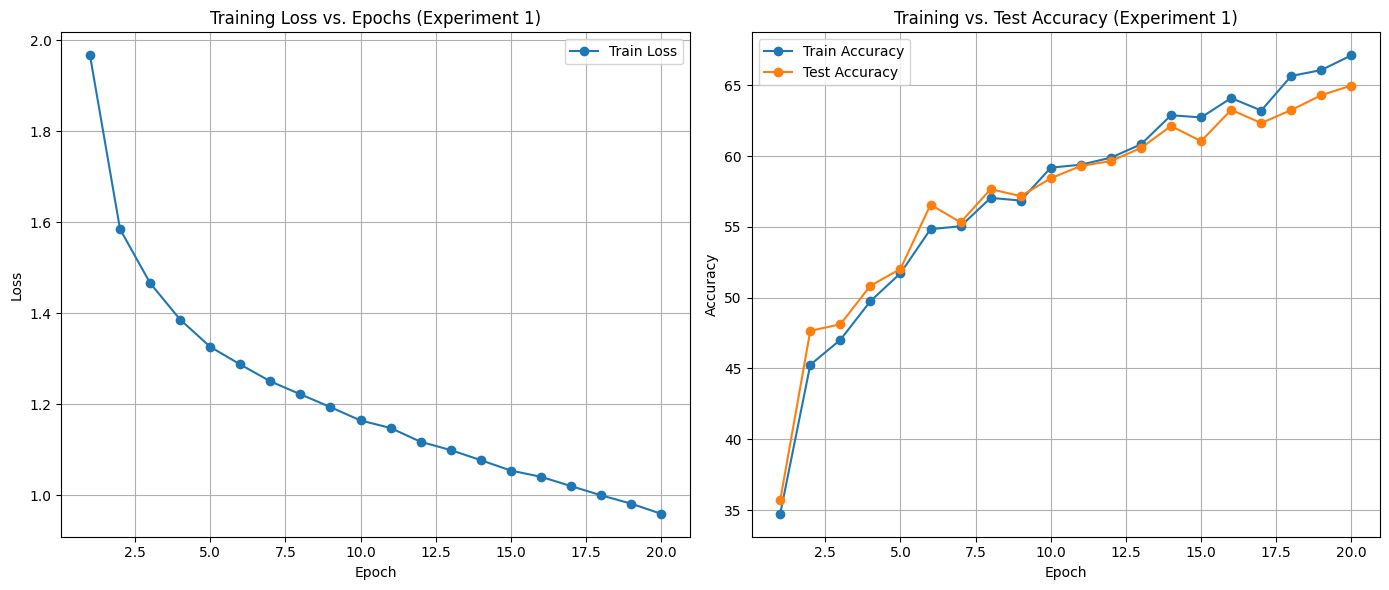

In [10]:
import matplotlib.pyplot as plt

# Assuming train_losses_exp1, train_accs, and test_accs_exp1 are available.
epochs = range(1, len(train_losses_exp1) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 1. Training Loss vs. Epochs
ax1.plot(epochs, train_losses_exp1, marker='o', label='Train Loss')
ax1.set_title('Training Loss vs. Epochs (Experiment 1)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

# 2. Combined Training and Test Accuracy vs. Epochs
ax2.plot(epochs, train_accs, marker='o', label='Train Accuracy')
ax2.plot(epochs, test_accs_exp1, marker='o', label='Test Accuracy')
ax2.set_title('Training vs. Test Accuracy (Experiment 1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


## Experiment 2: Varying Training Data Size

We train the same model architecture on different fractions of the training data: 5%, 10%, 25%, 50%, and 100%.

In [ ]:
# data_fractions
data_fractions = [0.05, 0.10, 0.25, 0.50, 1.0]
exp2_final_results = {}         # Final test accuracy per fraction
exp2_train_losses = {}          # Training loss curves per fraction
exp2_train_accs = {}            # Training accuracy curves per fraction
exp2_test_accs = {}             # Test accuracy curves per fraction

for frac in data_fractions:
    print(f"\nExperiment 2: Training with {int(frac*100)}% of the training data")
    train_loader_frac, _ = get_cifar10_dataloaders(data_fraction=frac)
    model = VisionTransformer(img_size=32, patch_size=4, stride=4, num_classes=10,
                              embed_dim=64, depth=6, num_heads=4).to(device)
    train_losses, train_accs, test_accs = train_model(model, train_loader_frac, test_loader, num_epochs=20, lr=1e-3)
    
    exp2_final_results[frac] = test_accs[-1]
    exp2_train_losses[frac] = train_losses
    exp2_train_accs[frac] = train_accs
    exp2_test_accs[frac] = test_accs

print("\nExperiment 2 Results (Final Test Accuracies):")
for frac, acc in exp2_final_results.items():
    print(f"  Data Fraction {int(frac*100)}%: {acc:.2f}%")




Experiment 2: Training with 5% of the training data
Epoch [1/20] Loss: 2.4143 | Train Acc: 14.32% | Test Acc: 12.22% | Time: 1.3s
Epoch [2/20] Loss: 2.2427 | Train Acc: 19.20% | Test Acc: 18.82% | Time: 1.4s
Epoch [3/20] Loss: 2.1875 | Train Acc: 19.16% | Test Acc: 18.68% | Time: 1.3s
Epoch [4/20] Loss: 2.0924 | Train Acc: 22.36% | Test Acc: 22.12% | Time: 1.4s
Epoch [5/20] Loss: 2.0267 | Train Acc: 24.84% | Test Acc: 22.46% | Time: 1.3s
Epoch [6/20] Loss: 1.9743 | Train Acc: 28.32% | Test Acc: 27.60% | Time: 1.3s
Epoch [7/20] Loss: 1.9366 | Train Acc: 27.92% | Test Acc: 28.56% | Time: 1.3s
Epoch [8/20] Loss: 1.9170 | Train Acc: 29.08% | Test Acc: 27.20% | Time: 1.4s
Epoch [9/20] Loss: 1.8724 | Train Acc: 31.36% | Test Acc: 30.61% | Time: 1.4s
Epoch [10/20] Loss: 1.7871 | Train Acc: 34.48% | Test Acc: 33.58% | Time: 1.3s
Epoch [11/20] Loss: 1.7487 | Train Acc: 33.04% | Test Acc: 33.16% | Time: 1.4s
Epoch [12/20] Loss: 1.7510 | Train Acc: 34.96% | Test Acc: 33.30% | Time: 1.4s
Epoch [1

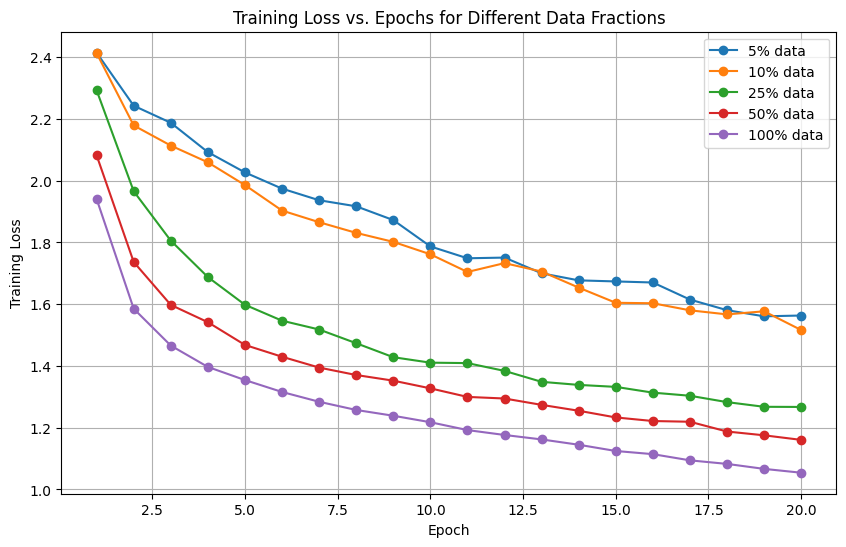

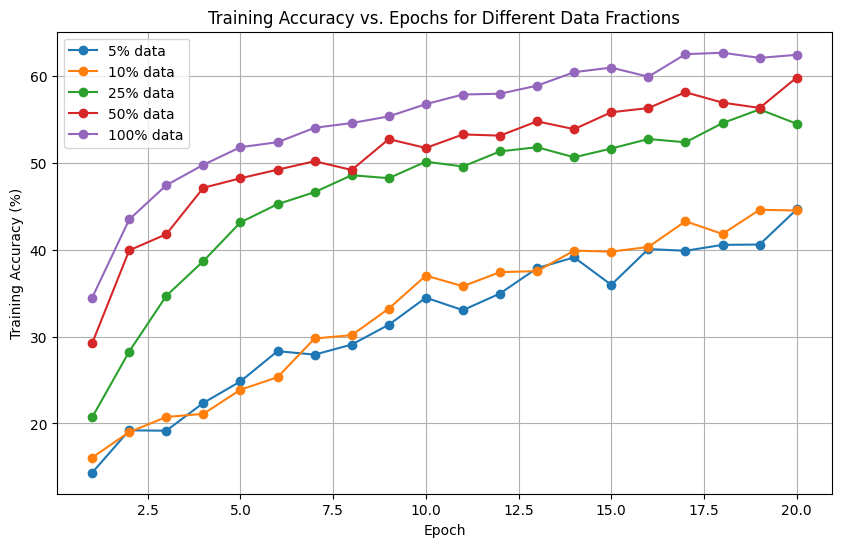

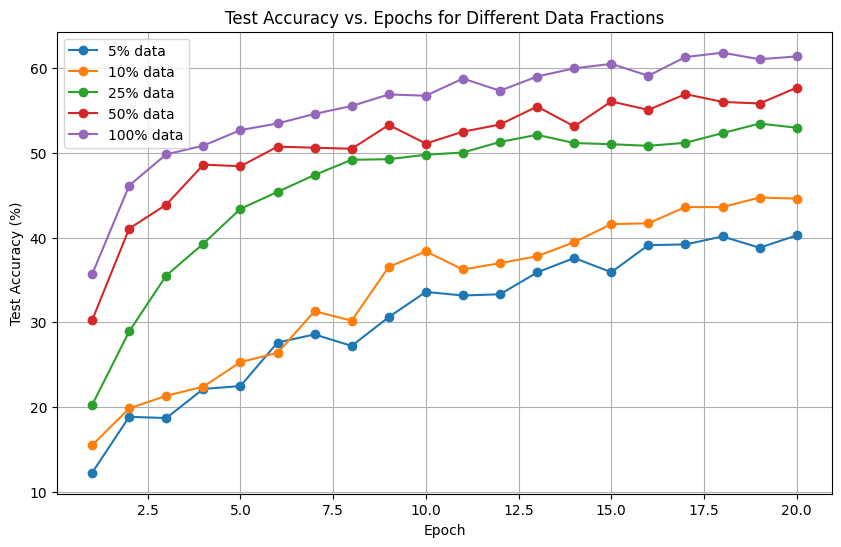

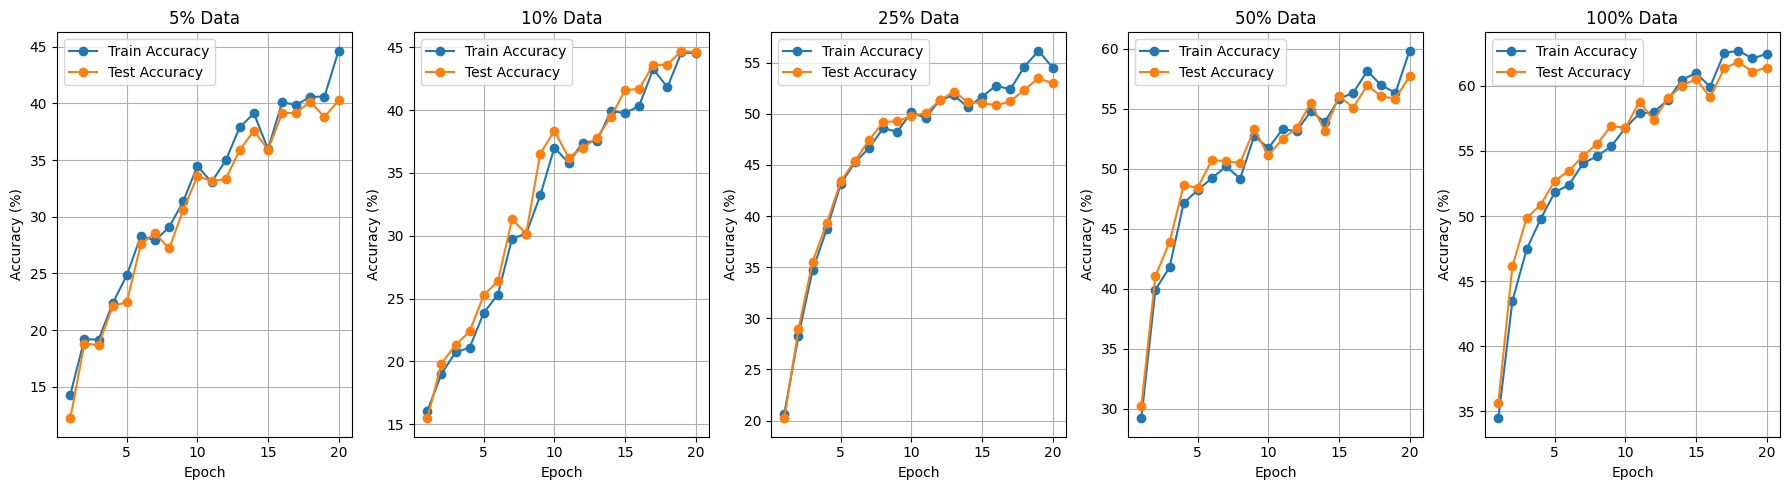

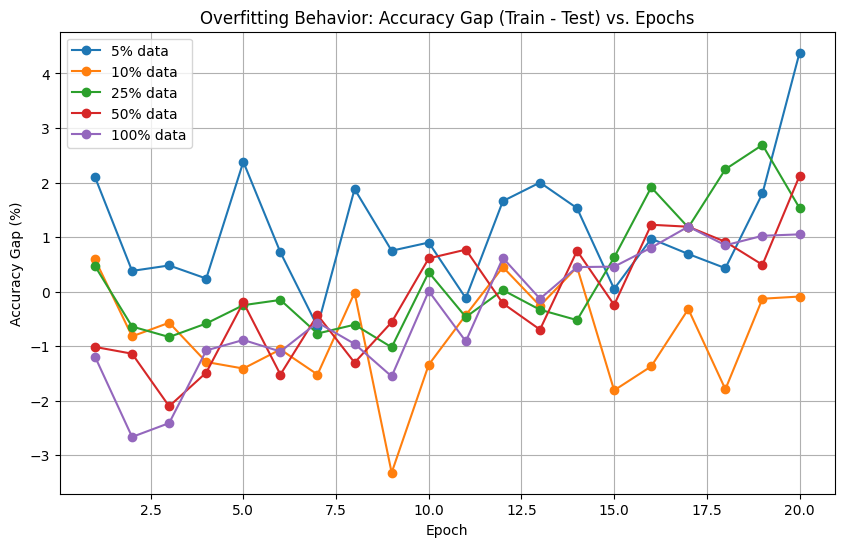

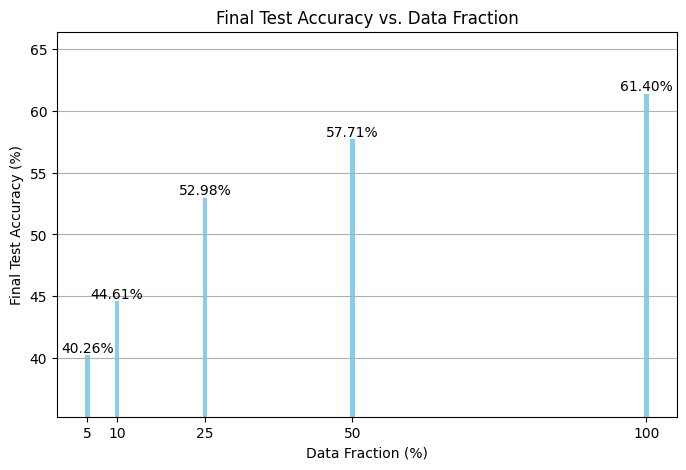

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Assume these dictionaries are populated from your experiment
# exp2_train_losses, exp2_train_accs, exp2_test_accs, exp2_final_results

data_fractions = sorted(exp2_train_losses.keys())
epochs = range(1, len(next(iter(exp2_train_losses.values()))) + 1)

# --- 1. Learning Curves per Data Fraction ---

# a) Training Loss Curves
plt.figure(figsize=(10, 6))
for frac in data_fractions:
    plt.plot(epochs, exp2_train_losses[frac], marker='o', label=f"{int(frac*100)}% data")
plt.title("Training Loss vs. Epochs for Different Data Fractions")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

# b) Training Accuracy Curves
plt.figure(figsize=(10, 6))
for frac in data_fractions:
    plt.plot(epochs, exp2_train_accs[frac], marker='o', label=f"{int(frac*100)}% data")
plt.title("Training Accuracy vs. Epochs for Different Data Fractions")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# c) Test Accuracy Curves
plt.figure(figsize=(10, 6))
for frac in data_fractions:
    plt.plot(epochs, exp2_test_accs[frac], marker='o', label=f"{int(frac*100)}% data")
plt.title("Test Accuracy vs. Epochs for Different Data Fractions")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()

# --- 2. Combined Training and Test Accuracy Curves per Data Fraction ---
fig, axs = plt.subplots(1, len(data_fractions), figsize=(18, 5))

for i, frac in enumerate(data_fractions):
    axs[i].plot(epochs, exp2_train_accs[frac], marker='o', label="Train Accuracy")
    axs[i].plot(epochs, exp2_test_accs[frac], marker='o', label="Test Accuracy")
    axs[i].set_title(f"{int(frac*100)}% Data")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()

# --- 3. Overfitting Behavior: Accuracy Gap (Train - Test) ---
plt.figure(figsize=(10, 6))
for frac in data_fractions:
    accuracy_gap = np.array(exp2_train_accs[frac]) - np.array(exp2_test_accs[frac])
    plt.plot(epochs, accuracy_gap, marker='o', label=f"{int(frac*100)}% data")
plt.title("Overfitting Behavior: Accuracy Gap (Train - Test) vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy Gap (%)")
plt.grid(True)
plt.legend()
plt.show()

# --- 4. Final Test Accuracy vs. Data Fraction ---
fractions_percent = [int(frac*100) for frac in data_fractions]
final_accuracies = [exp2_final_results[frac] for frac in data_fractions]

plt.figure(figsize=(8, 5))
bars = plt.bar(fractions_percent, final_accuracies, color='skyblue')
plt.title("Final Test Accuracy vs. Data Fraction")
plt.xlabel("Data Fraction (%)")
plt.ylabel("Final Test Accuracy (%)")
plt.xticks(fractions_percent)
plt.ylim([min(final_accuracies) - 5, max(final_accuracies) + 5])
plt.grid(axis='y')

# Adding data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom')

plt.show()


## Experiment 3: Varying Patch Size (and Overlap)

We compare non-overlapping patch sizes 4×4, 8×8, and 16×16.
We also try overlapping patches:
- For 4×4 patches with stride 2 (50% overlap)
- For 8×8 patches with stride 4 (50% overlap)

In [ ]:
# Define patch configurations (different patch sizes and overlap settings)
patch_configs = [
    {"patch_size": 4, "stride": 4, "desc": "4x4 non-overlapping"},
    {"patch_size": 4, "stride": 2, "desc": "4x4 with 50% overlap"},

    {"patch_size": 8, "stride": 8, "desc": "8x8 non-overlapping"},
    {"patch_size": 8, "stride": 4, "desc": "8x8 with 50% overlap"},

    {"patch_size": 16, "stride": 16, "desc": "16x16 non-overlapping"},
    {"patch_size": 16, "stride": 8, "desc": "16x16 with 50% overlap"},
]

# Dictionaries to store results:
exp3_final_results = {}      # Final test accuracy for each configuration
exp3_learning_curves = {}    # Test accuracy over epochs for each configuration
exp3_loss_curves = {}        # Training loss over epochs for each configuration

# Loop over each patch configuration and train the model
for config in patch_configs:
    print(f"\nExperiment 3: {config['desc']}")
    train_loader, _ = get_cifar10_dataloaders(data_fraction=1.0)
    model = VisionTransformer(img_size=32, patch_size=config["patch_size"], stride=config["stride"], num_classes=10,
                              embed_dim=64, depth=6, num_heads=4).to(device)
    train_losses,_,test_accs = train_model(model, train_loader, test_loader, num_epochs=20, lr=1e-3)
    exp3_final_results[config["desc"]] = test_accs[-1]
    exp3_learning_curves[config["desc"]] = test_accs
    exp3_loss_curves[config["desc"]] = train_losses

print("\nExperiment 3 Results (Final Test Accuracies):")
for desc, acc in exp3_final_results.items():
    print(f"  {desc}: {acc:.2f}%")



Experiment 3: 4x4 non-overlapping
Epoch [1/20] Loss: 1.9422 Test Acc: 38.68% Time: 9.3s
Epoch [2/20] Loss: 1.5629 Test Acc: 46.44% Time: 9.3s
Epoch [3/20] Loss: 1.4475 Test Acc: 51.69% Time: 9.3s
Epoch [4/20] Loss: 1.3872 Test Acc: 51.57% Time: 9.3s
Epoch [5/20] Loss: 1.3459 Test Acc: 52.70% Time: 9.3s
Epoch [6/20] Loss: 1.3083 Test Acc: 54.94% Time: 9.3s
Epoch [7/20] Loss: 1.2763 Test Acc: 53.79% Time: 9.3s
Epoch [8/20] Loss: 1.2564 Test Acc: 55.45% Time: 9.3s
Epoch [9/20] Loss: 1.2304 Test Acc: 57.60% Time: 9.3s
Epoch [10/20] Loss: 1.2016 Test Acc: 57.42% Time: 9.4s
Epoch [11/20] Loss: 1.1796 Test Acc: 57.89% Time: 9.3s
Epoch [12/20] Loss: 1.1629 Test Acc: 58.18% Time: 9.3s
Epoch [13/20] Loss: 1.1541 Test Acc: 58.50% Time: 9.3s
Epoch [14/20] Loss: 1.1274 Test Acc: 60.41% Time: 9.3s
Epoch [15/20] Loss: 1.1104 Test Acc: 59.44% Time: 9.2s
Epoch [16/20] Loss: 1.0935 Test Acc: 59.89% Time: 9.3s
Epoch [17/20] Loss: 1.0733 Test Acc: 61.58% Time: 9.3s
Epoch [18/20] Loss: 1.0635 Test Acc: 60

/tmp/ipykernel_503864/3550711308.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_descs, rotation=45, ha='right')
/tmp/ipykernel_503864/3550711308.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_descs, rotation=45, ha='right')
/tmp/ipykernel_503864/3550711308.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(group_descs, rotation=45, ha='right')


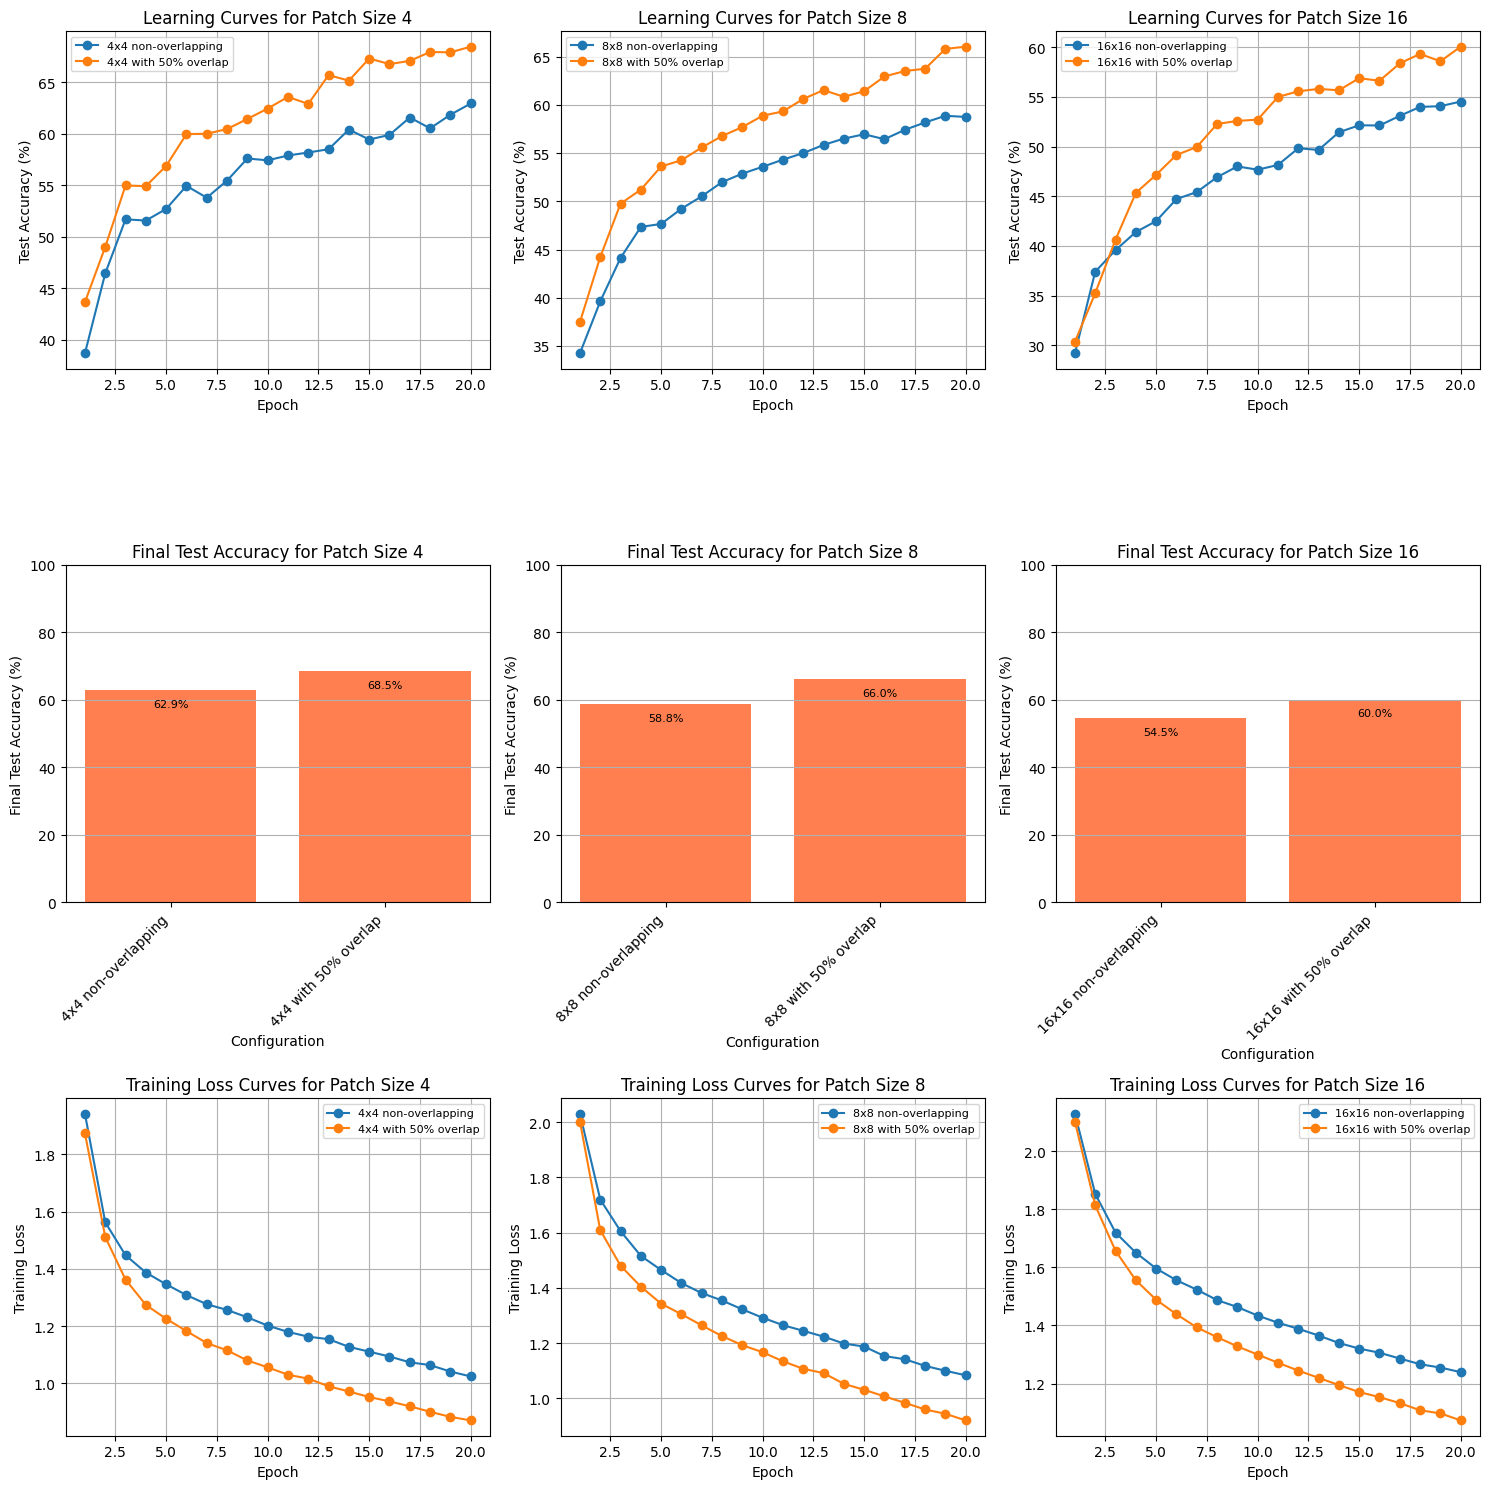

In [ ]:
import matplotlib.pyplot as plt

# Group patch configurations by patch size
patch_groups = {}
for config in patch_configs:
    ps = config["patch_size"]
    if ps not in patch_groups:
        patch_groups[ps] = []
    patch_groups[ps].append(config["desc"])

epochs = list(range(1, 21))  # assuming 20 epochs

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, ps in enumerate(sorted(patch_groups.keys())):
    group_descs = patch_groups[ps]
    
    # Graph 1: Learning Curves for Patch Size 'ps'
    ax = axes[i]
    for desc in group_descs:
        ax.plot(epochs, exp3_learning_curves[desc], marker='o', label=desc)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Test Accuracy (%)")
    ax.set_title(f"Learning Curves for Patch Size {ps}")
    ax.legend(fontsize=8)
    ax.grid(True)
    
    # Graph 2: Bar Chart of Final Test Accuracies for Patch Size 'ps'
    ax = axes[i + 3]
    final_accs_group = [exp3_final_results[desc] for desc in group_descs]
    bars = ax.bar(group_descs, final_accs_group, color='coral')
    ax.set_xlabel("Configuration")
    ax.set_ylabel("Final Test Accuracy (%)")
    ax.set_title(f"Final Test Accuracy for Patch Size {ps}")
    ax.set_ylim(0, 100)
    ax.set_xticklabels(group_descs, rotation=45, ha='right')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height - 5, f'{height:.1f}%', ha='center', fontsize=8)
    ax.grid(axis='y')
    
    # Graph 3: Training Loss Curves for Patch Size 'ps'
    
    ax = axes[i + 6]
    for desc in group_descs:
        ax.plot(epochs, exp3_loss_curves[desc], marker='o', label=desc)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    ax.set_title(f"Training Loss Curves for Patch Size {ps}")
    ax.legend(fontsize=8)
    ax.grid(True)

plt.tight_layout()
plt.show()


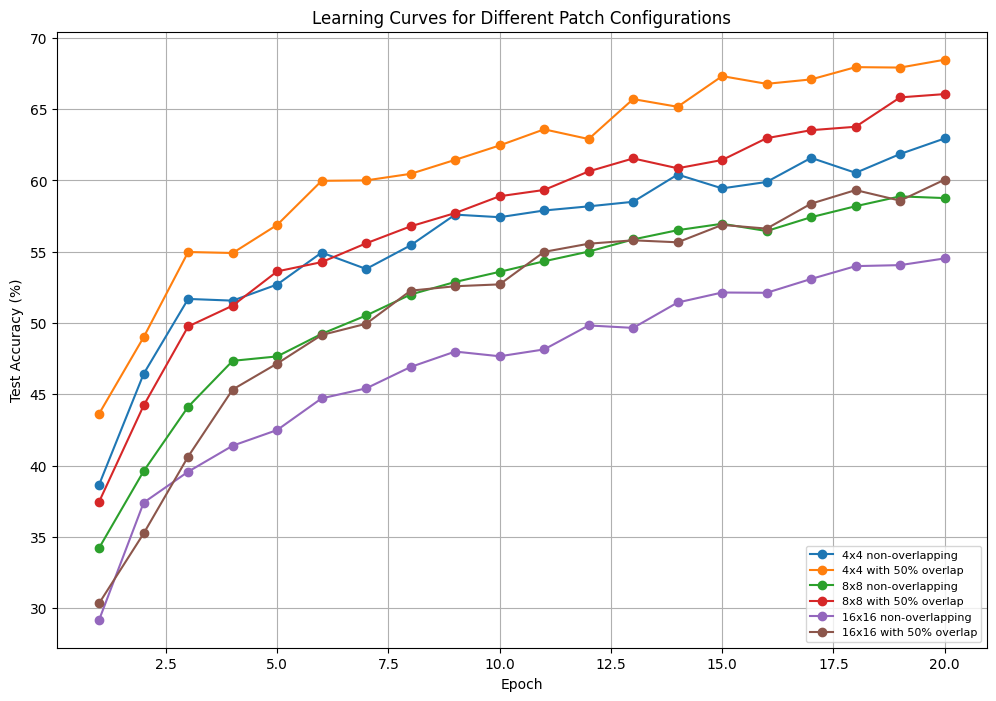

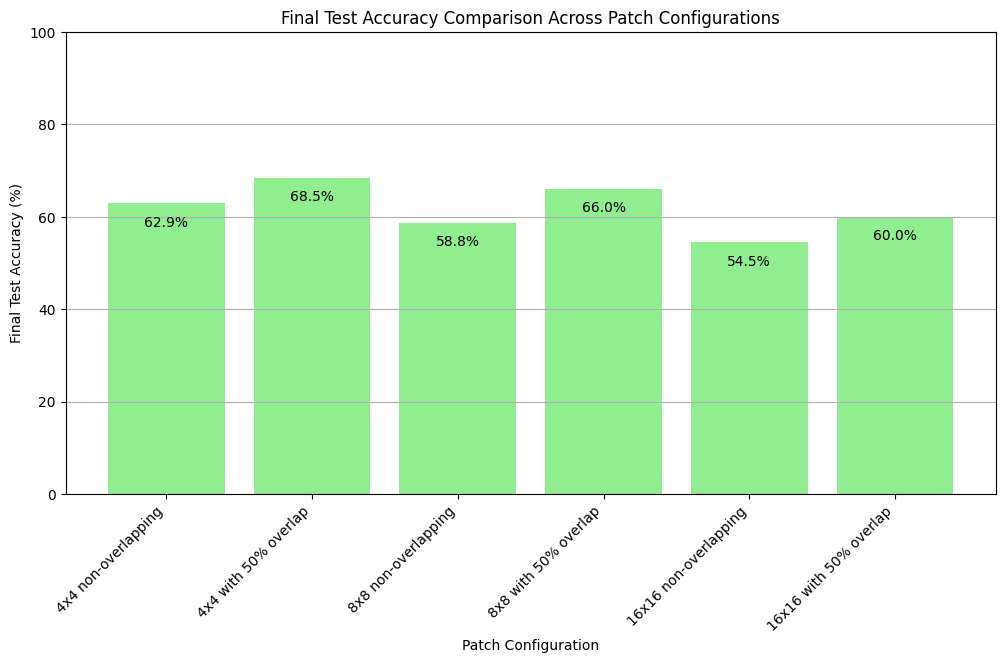

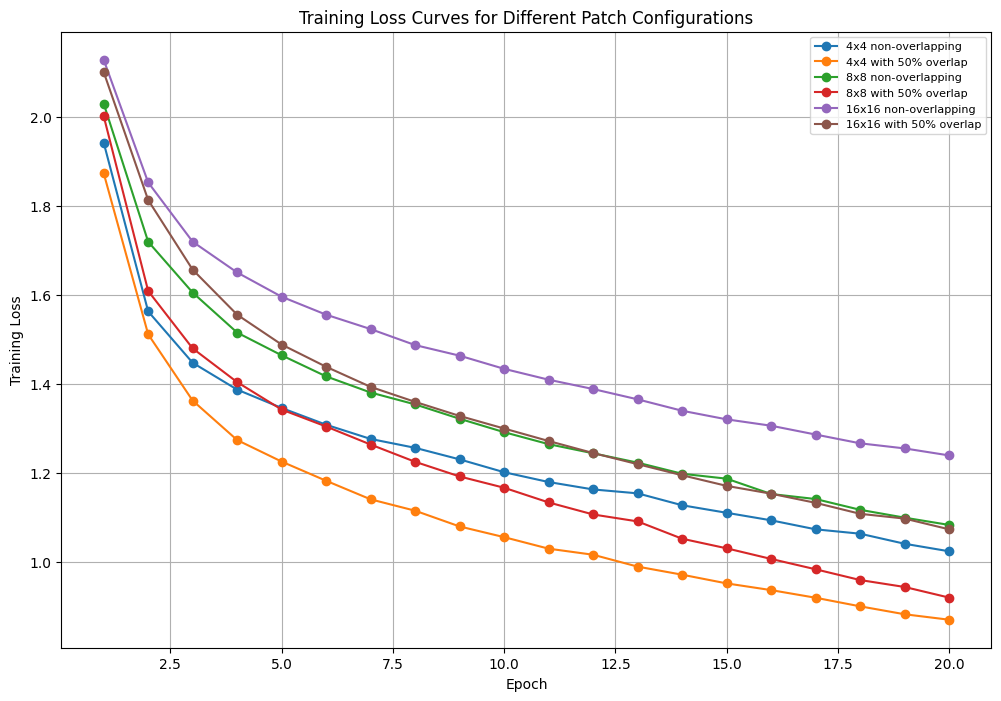

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Comparison Graph 1: Learning Curves (Test Accuracy vs. Epoch)

epochs = list(range(1, 21))  # Assuming 20 epochs

plt.figure(figsize=(12, 8))
for desc, accs in exp3_learning_curves.items():
    plt.plot(epochs, accs, marker='o', label=desc)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Learning Curves for Different Patch Configurations")
plt.legend(fontsize=8, loc='lower right')
plt.grid(True)
plt.show()

# Comparison Graph 2: Bar Chart of Final Test Accuracies

config_descs = list(exp3_final_results.keys())
final_accs = list(exp3_final_results.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(config_descs, final_accs, color='lightgreen')
plt.xlabel("Patch Configuration")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Final Test Accuracy Comparison Across Patch Configurations")
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 5, f'{height:.1f}%', ha='center', fontsize=10)
plt.grid(axis='y')
plt.show()



# Comparison Graph 4: Training Loss Curves (Training Loss vs. Epoch)

plt.figure(figsize=(12, 8))
for desc, losses in exp3_loss_curves.items():
    plt.plot(epochs, losses, marker='o', label=desc)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Patch Configurations")
plt.legend(fontsize=8, loc='upper right')
plt.grid(True)
plt.show()


## Experiment 4: Varying Number of Attention Heads

We test models with 2, 4, and 8 attention heads (keeping embed_dim fixed at 64).

In [60]:
head_configs = [1,2, 4, 8]
exp4_final_results = {}    # Final test accuracies for each head config
exp4_learning_curves = {}  # Test accuracy over epochs for each head config
exp4_loss_curves = {}      # Training loss over epochs for each head config
exp4_train_accs = {}       # Training accuracy over epochs for each head config

for heads in head_configs:
    print(f"\nExperiment 4: {heads} attention heads")
    train_loader, _ = get_cifar10_dataloaders(data_fraction=1.0)
    model = VisionTransformer(img_size=32, patch_size=4, stride=4, num_classes=10,
                              embed_dim=64, depth=6, num_heads=heads).to(device)
    train_losses,train_acc,test_accs = train_model(model, train_loader, test_loader, num_epochs=20, lr=1e-3)
    exp4_final_results[heads] = test_accs[-1]
    exp4_learning_curves[heads] = test_accs
    exp4_loss_curves[heads] = train_losses
    exp4_train_accs[heads] = train_acc
    
print("\nExperiment 4 Results (Final Test Accuracies):")
for heads, acc in exp4_final_results.items():
    print(f"  {heads} heads: {acc:.2f}%")


Experiment 4: 1 attention heads
Epoch [1/20] Loss: 2.0362 | Train Acc: 30.81% | Test Acc: 32.43% | Time: 10.9s
Epoch [2/20] Loss: 1.7596 | Train Acc: 37.35% | Test Acc: 38.92% | Time: 11.0s
Epoch [3/20] Loss: 1.6462 | Train Acc: 40.21% | Test Acc: 41.28% | Time: 11.1s
Epoch [4/20] Loss: 1.5649 | Train Acc: 44.02% | Test Acc: 47.15% | Time: 11.1s
Epoch [5/20] Loss: 1.4984 | Train Acc: 45.73% | Test Acc: 48.49% | Time: 11.0s
Epoch [6/20] Loss: 1.4442 | Train Acc: 48.24% | Test Acc: 49.68% | Time: 11.0s
Epoch [7/20] Loss: 1.4051 | Train Acc: 48.88% | Test Acc: 51.05% | Time: 11.1s
Epoch [8/20] Loss: 1.3873 | Train Acc: 50.36% | Test Acc: 51.48% | Time: 11.1s
Epoch [9/20] Loss: 1.3500 | Train Acc: 51.22% | Test Acc: 53.54% | Time: 11.0s
Epoch [10/20] Loss: 1.3250 | Train Acc: 51.96% | Test Acc: 52.63% | Time: 11.0s
Epoch [11/20] Loss: 1.3109 | Train Acc: 53.58% | Test Acc: 55.08% | Time: 11.0s
Epoch [12/20] Loss: 1.2840 | Train Acc: 54.25% | Test Acc: 54.67% | Time: 11.1s
Epoch [13/20] Lo

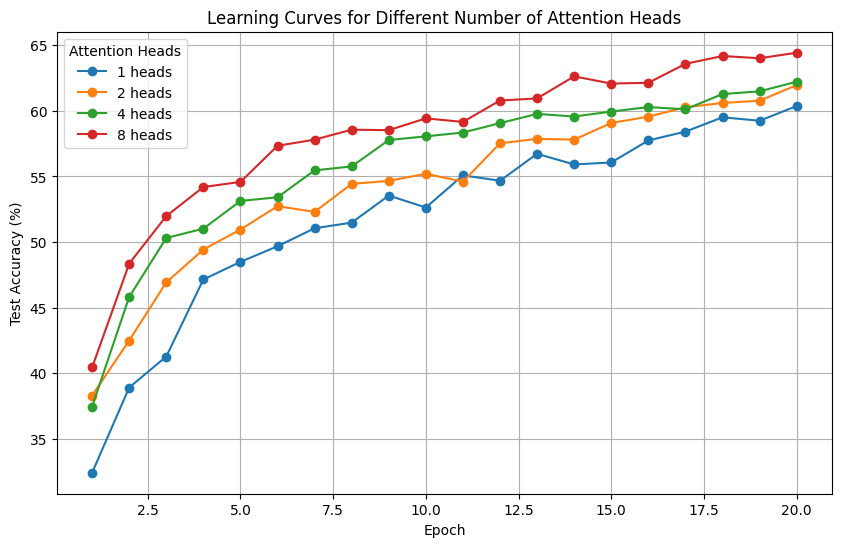

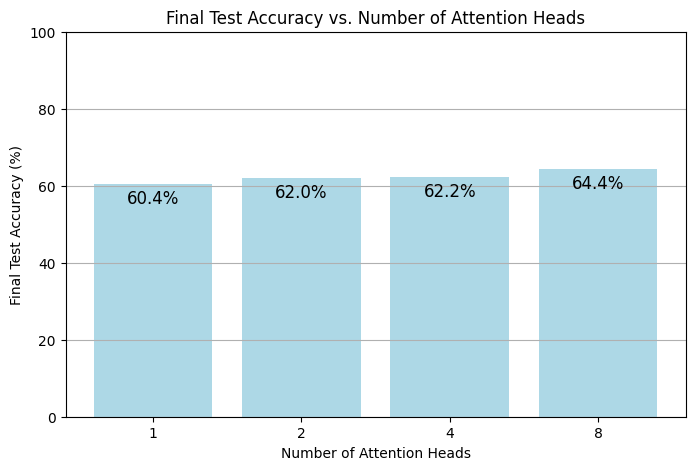

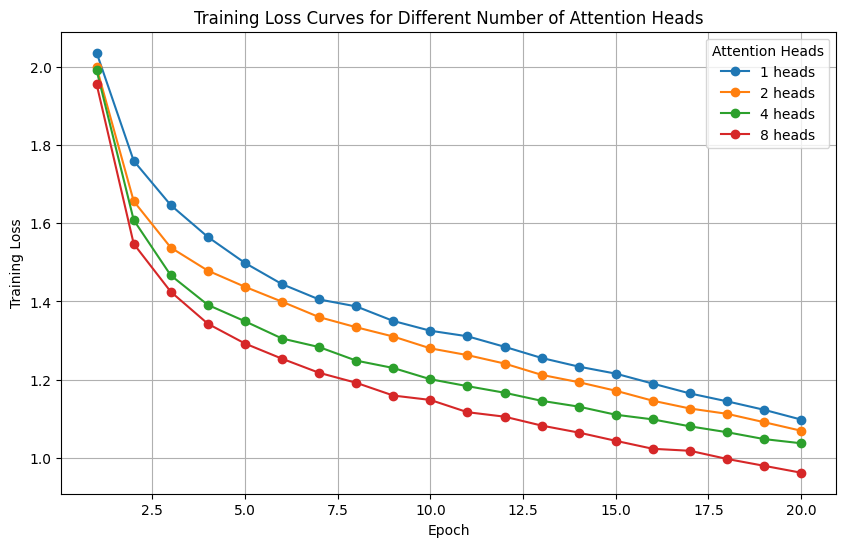

In [61]:

import matplotlib.pyplot as plt

epochs = list(range(1, 21))  # Assuming 20 epochs

# Graph 1: Learning Curves (Test Accuracy vs. Epoch)
plt.figure(figsize=(10, 6))
for heads, accs in exp4_learning_curves.items():
    plt.plot(epochs, accs, marker='o', label=f"{heads} heads")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Learning Curves for Different Number of Attention Heads")
plt.legend(title="Attention Heads")
plt.grid(True)
plt.show()

# Graph 2: Bar Chart of Final Test Accuracies
head_labels = [str(h) for h in head_configs]
final_acc_values = [exp4_final_results[h] for h in head_configs]

plt.figure(figsize=(8, 5))
bars = plt.bar(head_labels, final_acc_values, color='lightblue')
plt.xlabel("Number of Attention Heads")
plt.ylabel("Final Test Accuracy (%)")
plt.title("Final Test Accuracy vs. Number of Attention Heads")
plt.ylim(0, 100)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 5, f'{height:.1f}%', 
             ha='center', fontsize=12)
plt.grid(axis='y')
plt.show()


# Graph 4: Training Loss Curves (Training Loss vs. Epoch)
plt.figure(figsize=(10, 6))
for heads, losses in exp4_loss_curves.items():
    plt.plot(epochs, losses, marker='o', label=f"{heads} heads")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Number of Attention Heads")
plt.legend(title="Attention Heads")
plt.grid(True)
plt.show()


## Experiment 5: Classification Using CLS Token from Different Layers


In this experiment, we use the trained base model from Experiment 1.
We run a forward pass that returns the CLS token outputs from each transformer layer.
Then, using the final classification head (trained on the last layer's CLS token), we compute test accuracy using each layer's CLS token.




In [ ]:
def evaluate_cls_layers(model, dataloader):
    model.eval()
    cls_correct = [0] * len(model.layers)  # one counter per layer
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            logits, cls_outputs = model(images, return_layer_outputs=True)   # Get CLS outputs from each layer (return_layer_outputs=True)
            total += labels.size(0)
           
            for i, cls_out in enumerate(cls_outputs):   # Use the final head (model.head) on each CLS output
                logits_i = model.head(cls_out)
                _, preds = torch.max(logits_i, 1)
                cls_correct[i] += (preds == labels).sum().item()
    accs = [100.0 * correct / total for correct in cls_correct]
    return accs

print("\nExperiment 5: Evaluating CLS token outputs from each layer (base model)")
cls_layer_accs = evaluate_cls_layers(model_exp1, test_loader)
for i, acc in enumerate(cls_layer_accs):
    print(f"  Layer {i+1} CLS token accuracy: {acc:.2f}%")



Experiment 5: Evaluating CLS token outputs from each layer (base model)
  Layer 1 CLS token accuracy: 28.10%
  Layer 2 CLS token accuracy: 46.23%
  Layer 3 CLS token accuracy: 53.40%
  Layer 4 CLS token accuracy: 57.30%
  Layer 5 CLS token accuracy: 59.96%
  Layer 6 CLS token accuracy: 60.74%


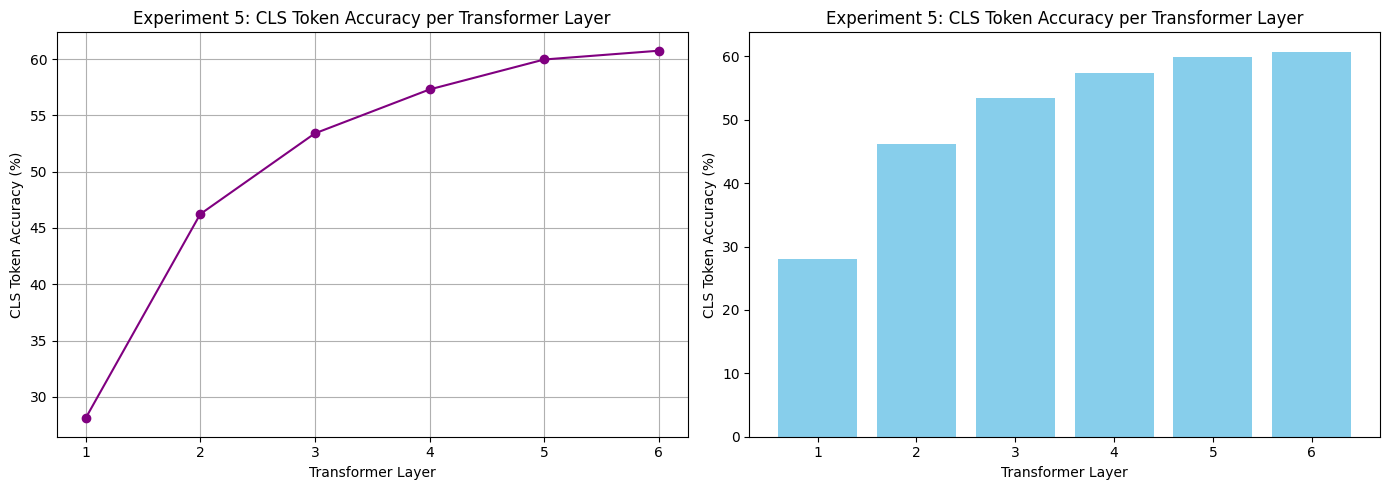

In [64]:
import matplotlib.pyplot as plt

# Assume cls_layer_accs is the list of accuracies per transformer layer.
layers = list(range(1, len(cls_layer_accs) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Line Plot
ax1.plot(layers, cls_layer_accs, marker='o', linestyle='-', color='purple')
ax1.set_xlabel("Transformer Layer")
ax1.set_ylabel("CLS Token Accuracy (%)")
ax1.set_title("Experiment 5: CLS Token Accuracy per Transformer Layer")
ax1.set_xticks(layers)
ax1.grid(True)

# Bar Chart
ax2.bar(layers, cls_layer_accs, color='skyblue')
ax2.set_xlabel("Transformer Layer")
ax2.set_ylabel("CLS Token Accuracy (%)")
ax2.set_title("Experiment 5: CLS Token Accuracy per Transformer Layer")
ax2.set_xticks(layers)

plt.tight_layout()
plt.show()


## Experiment 6: Attention Map Visualization

The procedure is as follows:
1. Run a forward pass with `return_attn=True` to get attention maps.
2. For each layer, extract the attention weights from the CLS token (index 0).
3. Reshape the attention weights (for non-overlapping patches) into a square grid.
4. Overlay the attention heatmap onto the original image.

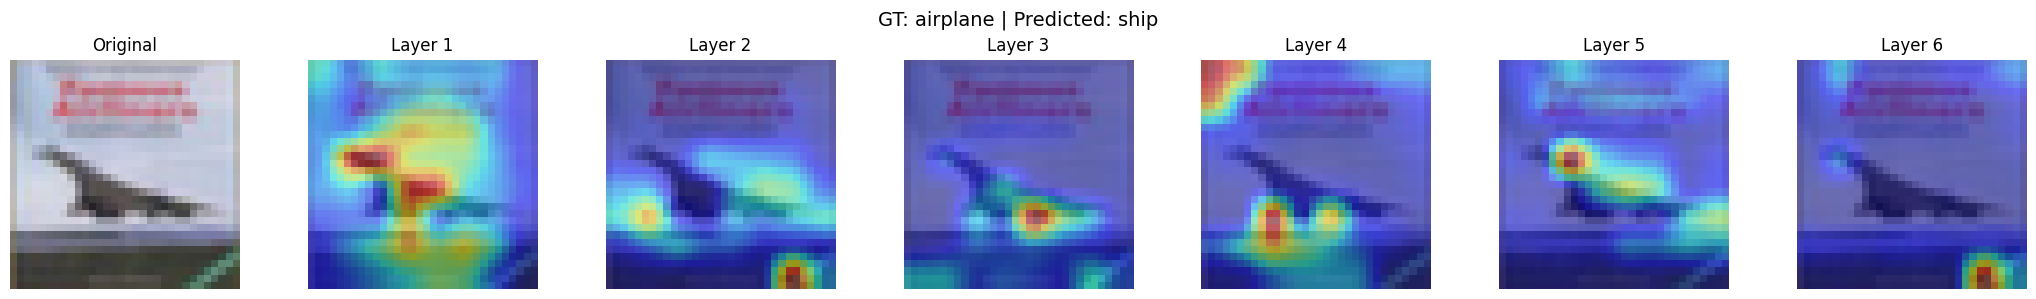

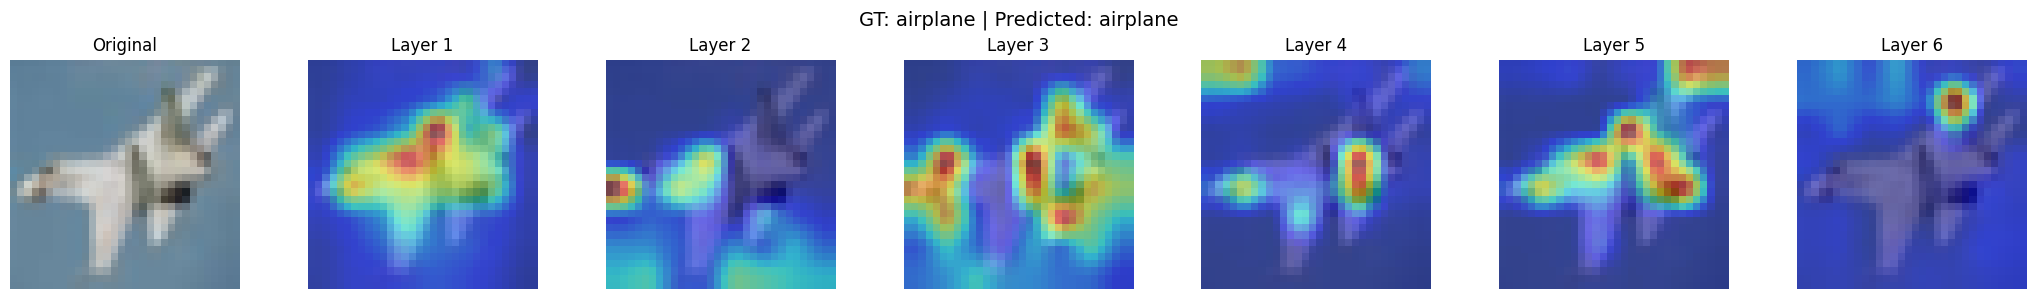

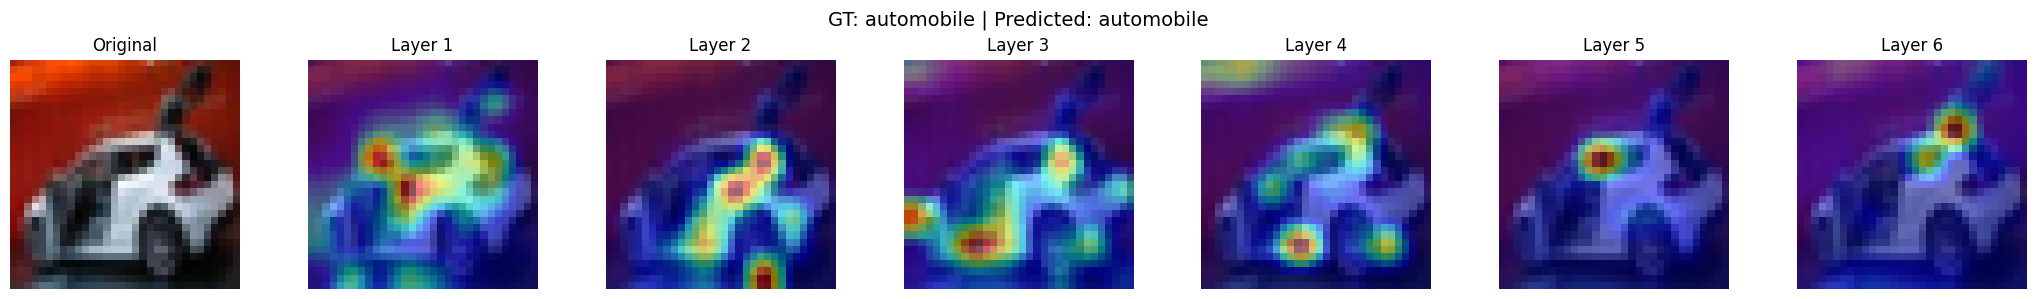

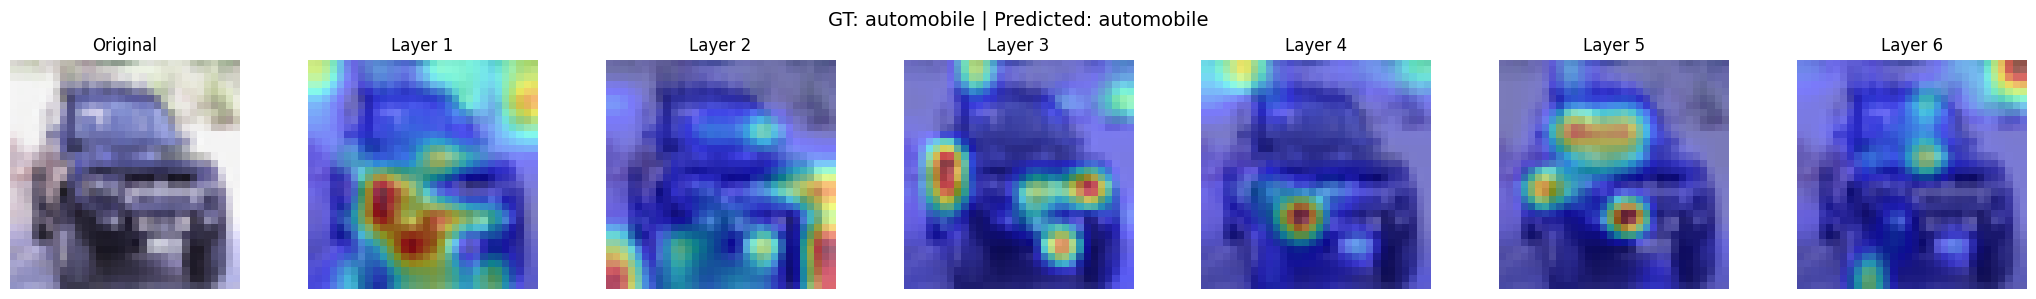

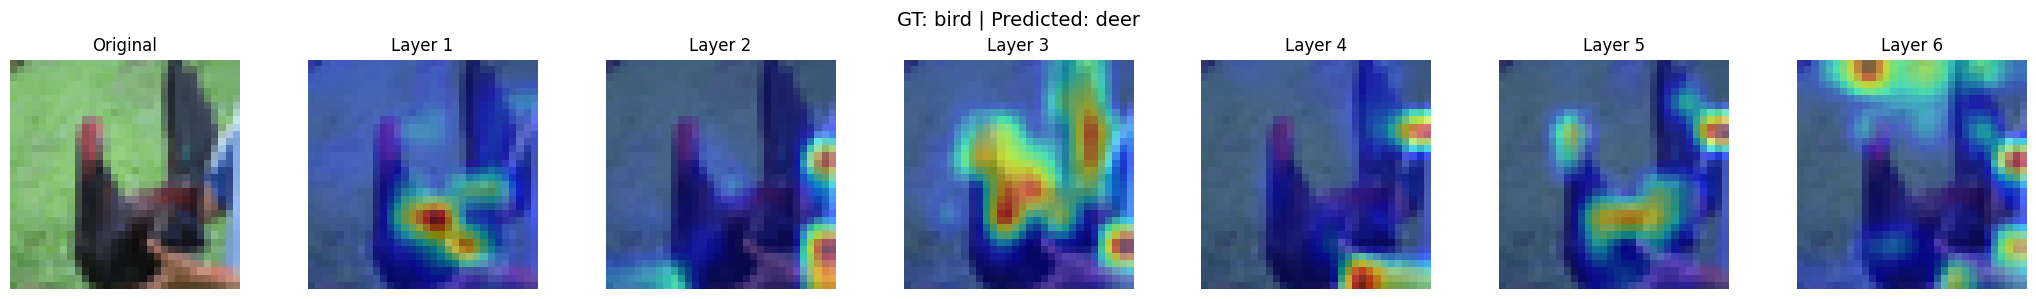

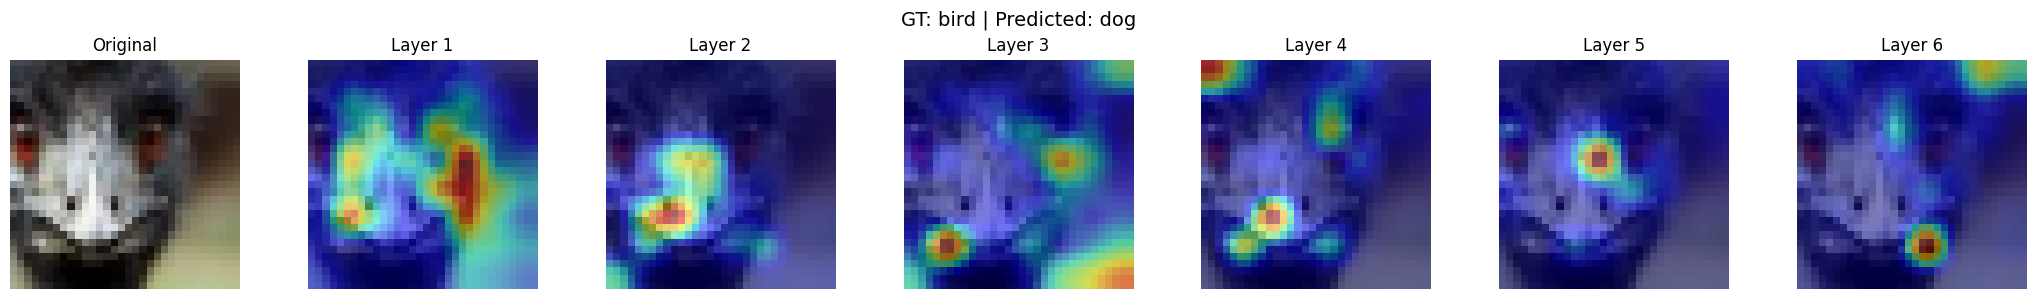

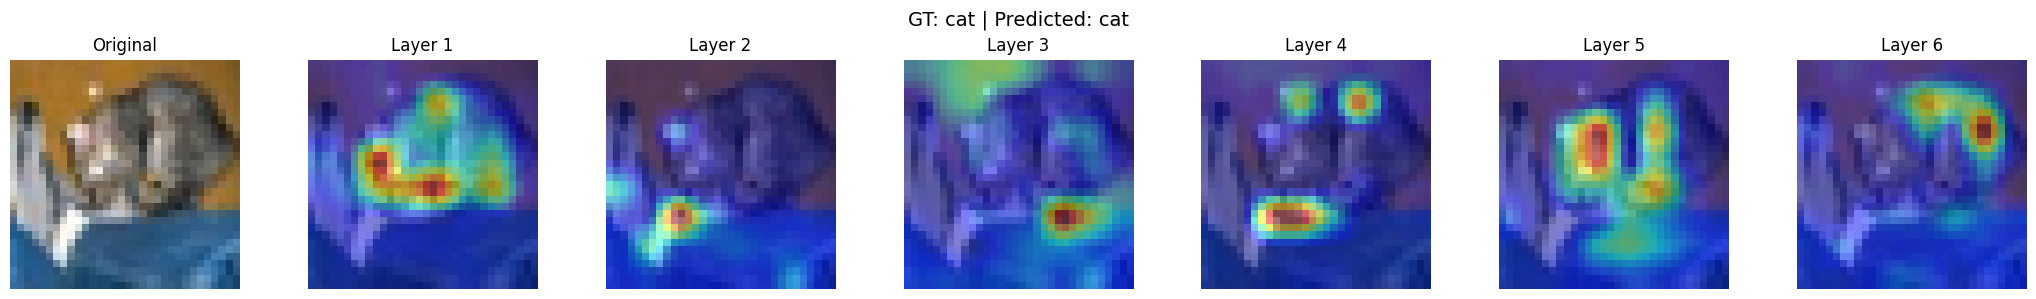

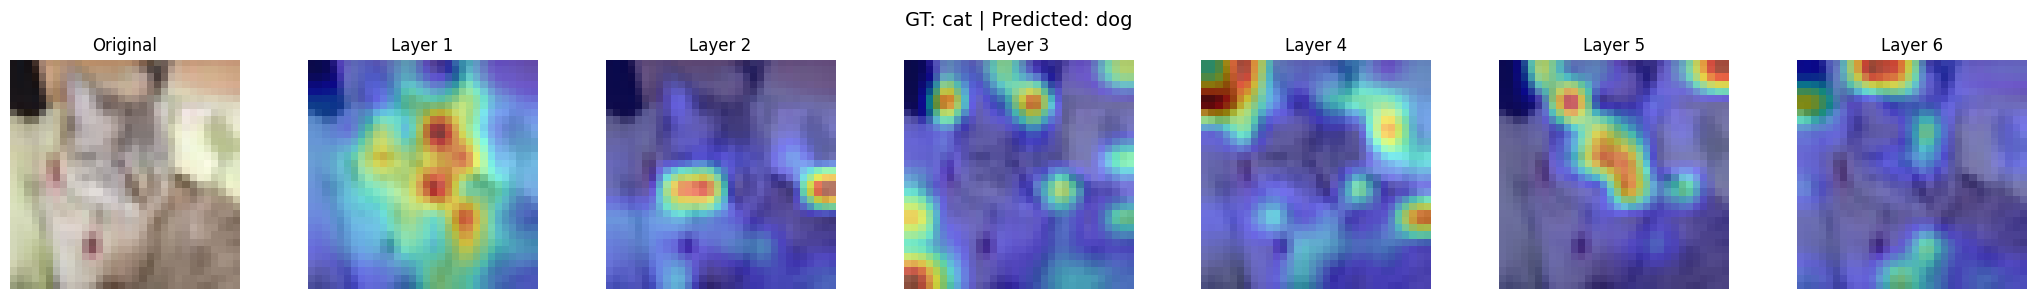

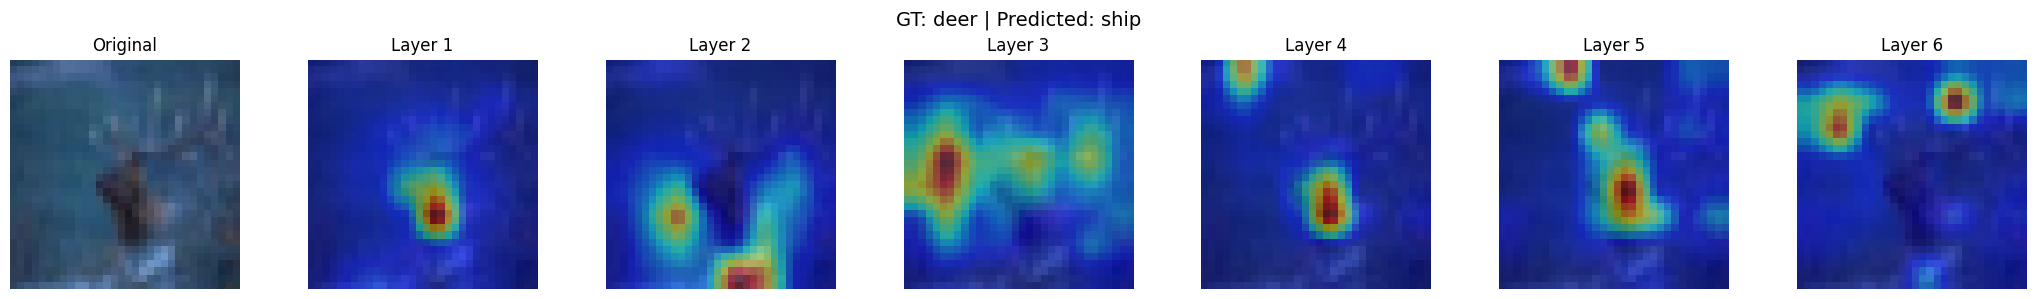

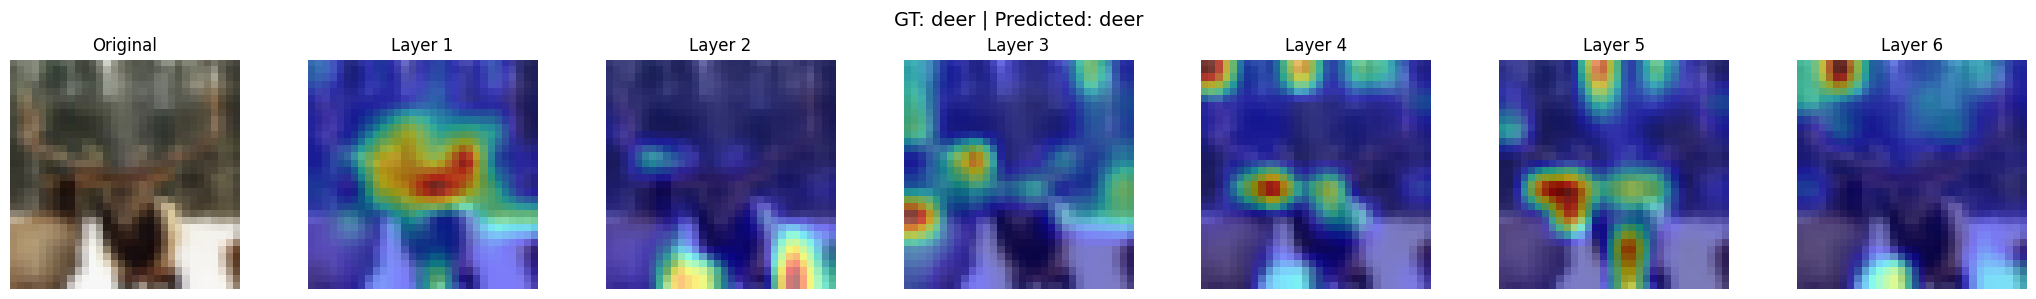

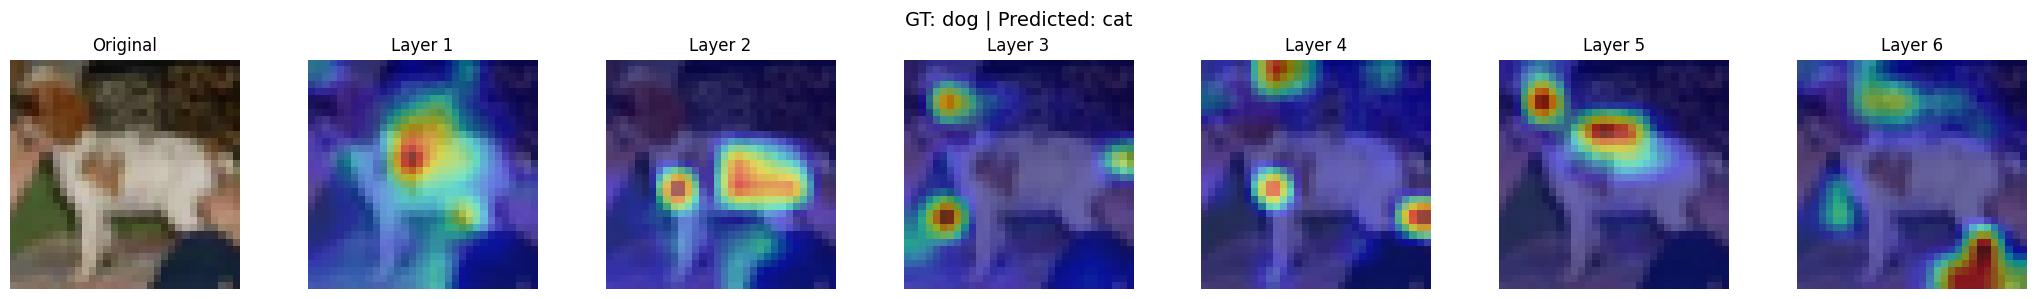

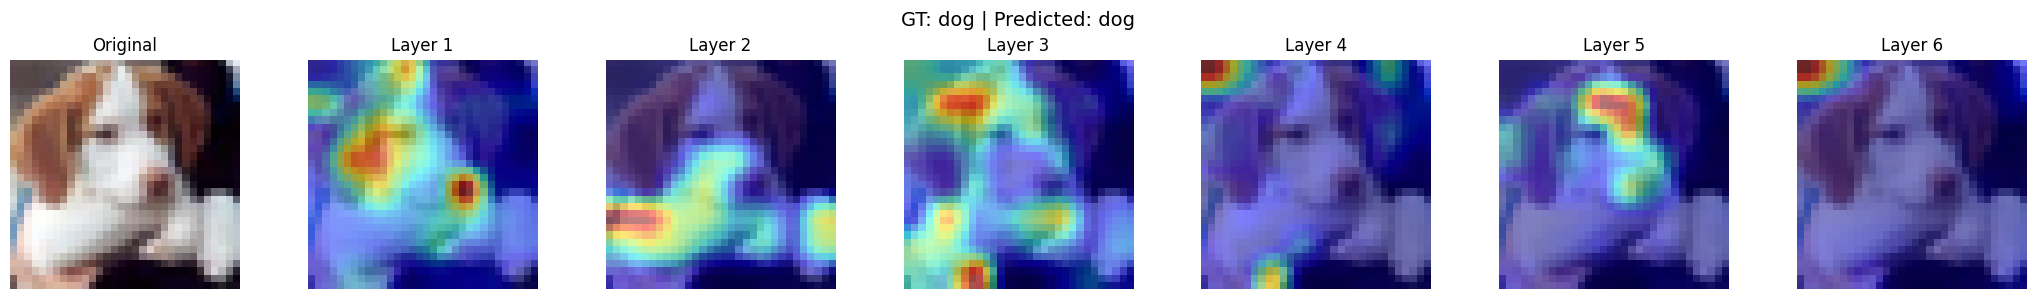

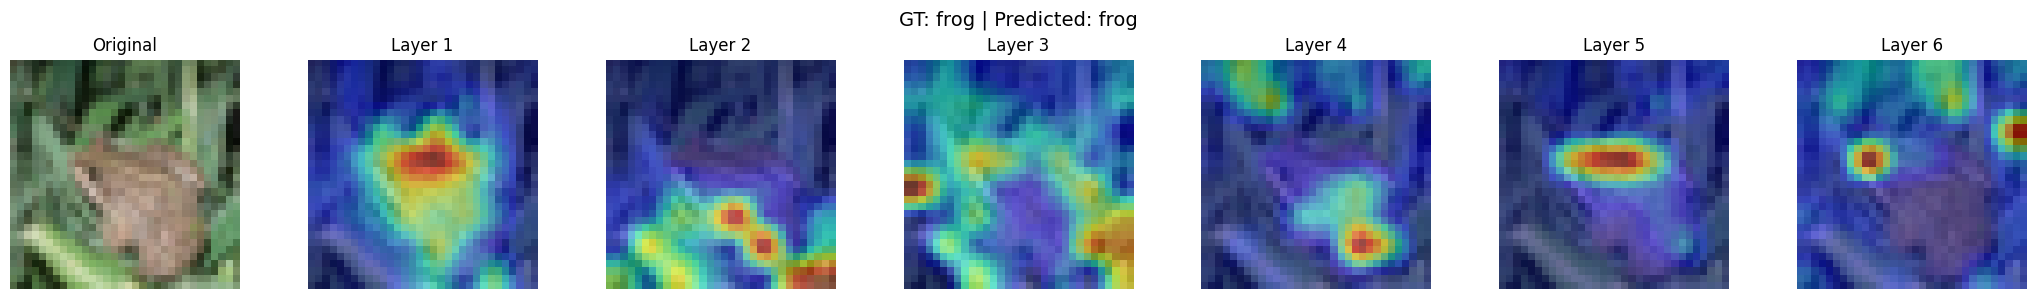

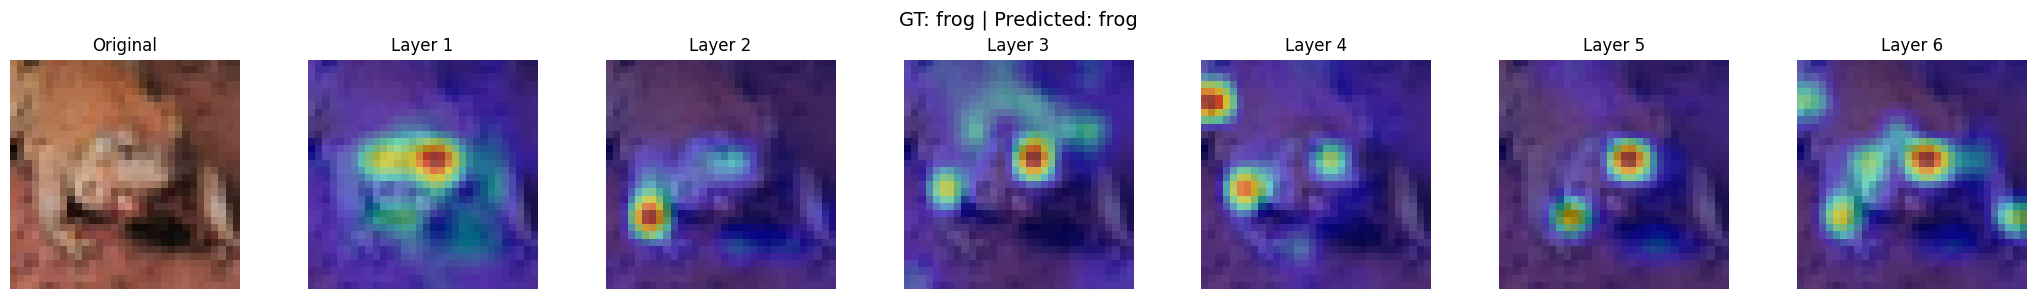

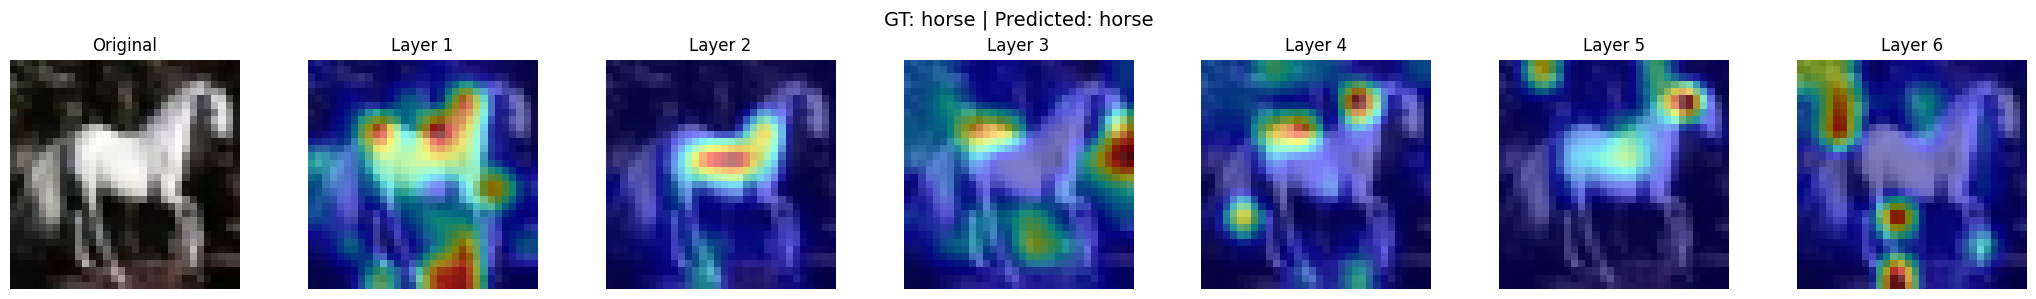

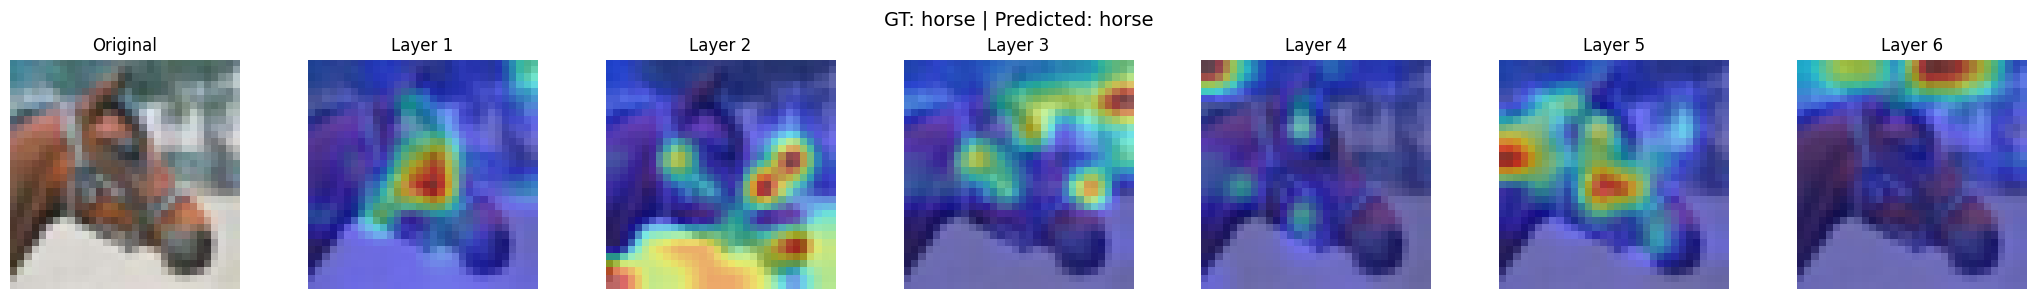

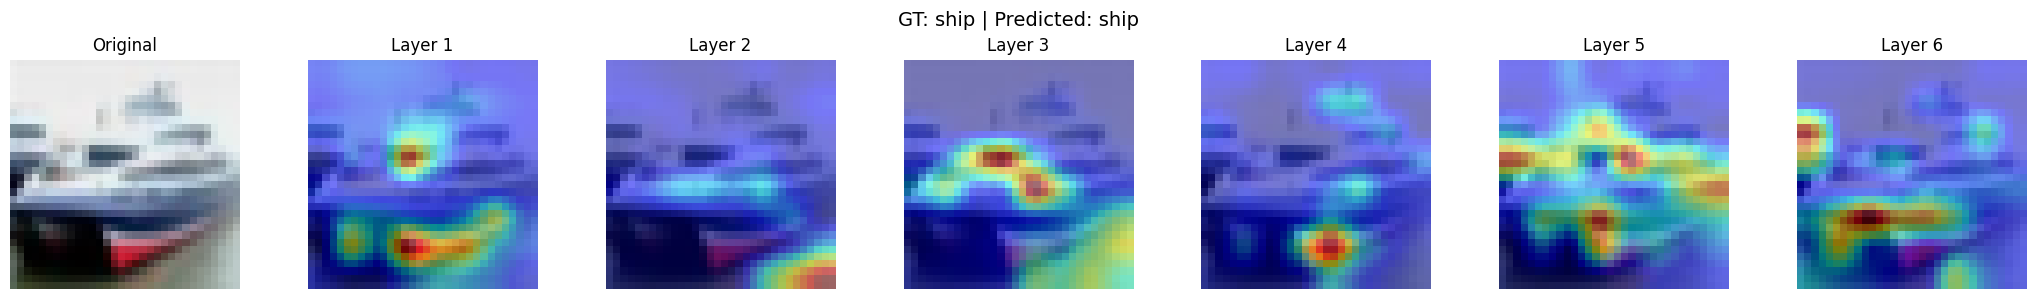

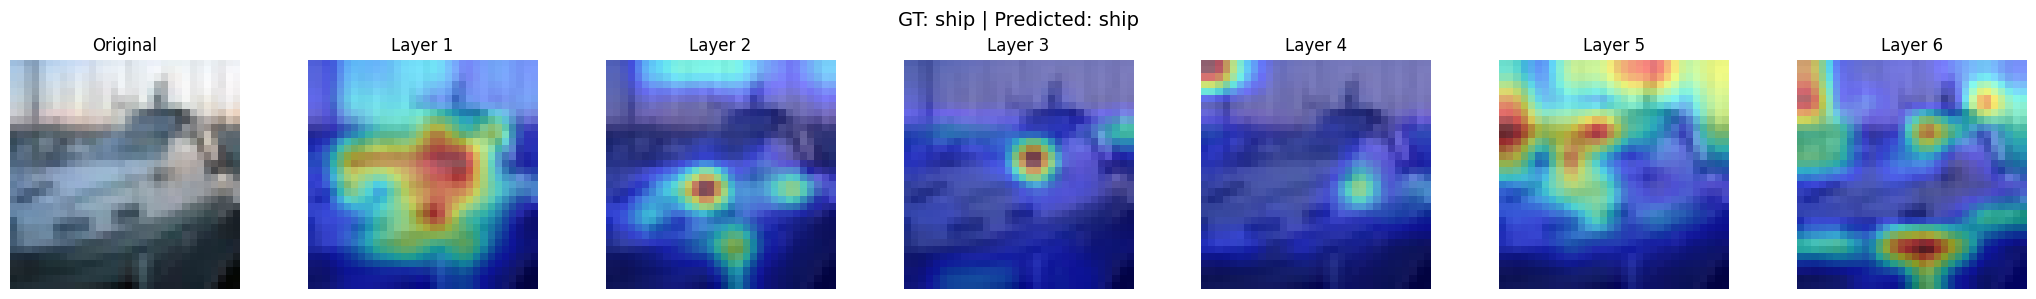

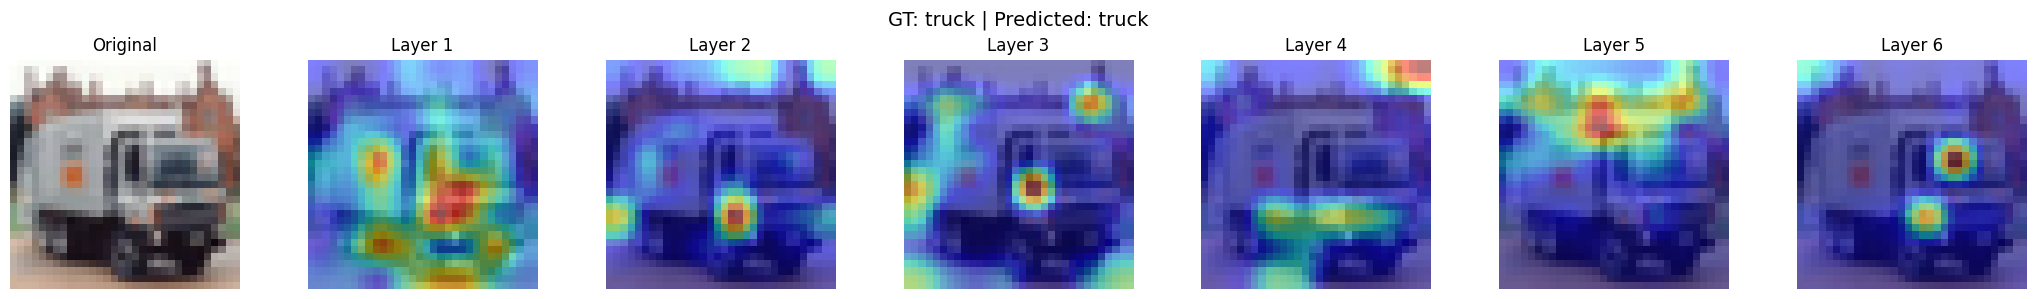

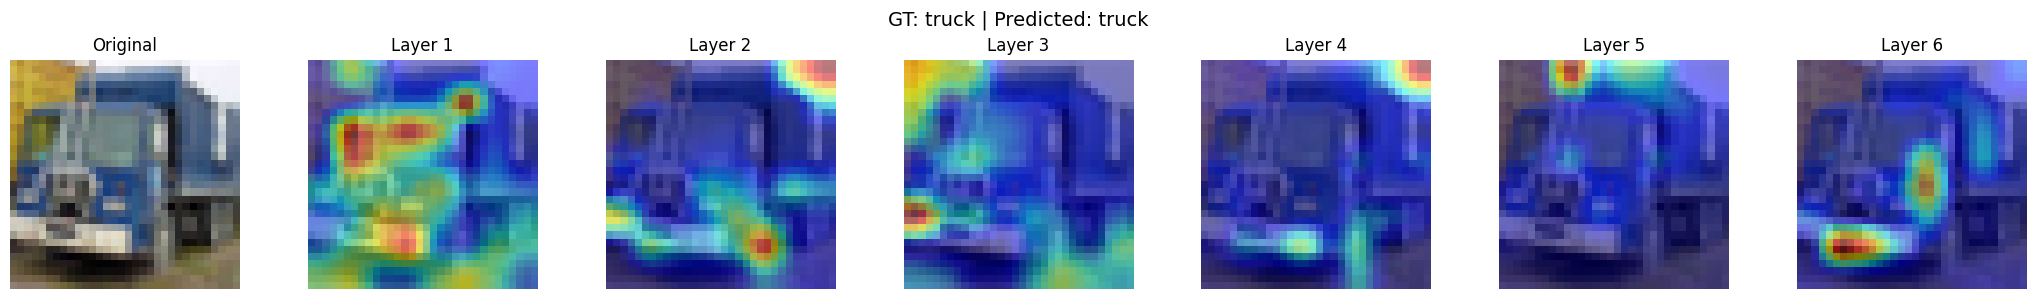

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torchvision import transforms, datasets

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

def plot_attention_on_axis(ax, image, attn_map, patch_size, stride, title=""):
    """
    Overlays the attention map on the provided axis.
    - ax: matplotlib axis.
    - image: (H, W, 3) numpy array (original image).
    - attn_map: 1D attention weights (one value per patch).
    - patch_size, stride: parameters used to compute grid dimensions.
    """
    H, W, _ = image.shape
    grid_rows = (H - patch_size) // stride + 1
    grid_cols = (W - patch_size) // stride + 1
    attn_grid = attn_map.reshape((grid_rows, grid_cols))
    attn_grid = np.clip(attn_grid, 0, 1)
    attn_resized = cv2.resize(attn_grid, (W, H))
    
    ax.imshow(image)
    ax.imshow(attn_resized, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(title)

def select_test_images_per_class(dataset, num_per_class=2):
    """
    Selects a specified number of images per class from the dataset.
    Returns a dictionary with class labels as keys and lists of images as values.
    """
    class_images = {i: [] for i in range(10)}
    class_counts = {i: 0 for i in range(10)}
    
    for img, label in dataset:
        if class_counts[label] < num_per_class:
            class_images[label].append(img)
            class_counts[label] += 1
        if all(count >= num_per_class for count in class_counts.values()):
            break
    
    return class_images

def get_attention_maps(model, image_tensor):
    """
    image_tensor: (1, C, H, W)
    Returns: List of attention maps (one per transformer layer)
    Each attention map is the attention of the CLS token to all patches.
    """
    model.eval()
    with torch.no_grad():
        _, attn_maps = model(image_tensor, return_attn=True)
    cls_attn_maps = []
    for attn in attn_maps:
        attn_cls = attn[0, :, 0, 1:]  # shape: (num_heads, N-1)
        attn_mean = attn_cls.mean(dim=0)    # Average over heads to get single layer map over attention heads
        cls_attn_maps.append(attn_mean.cpu().numpy())
    return cls_attn_maps

# Load the CIFAR-10 test dataset (without normalization for visualization)
transform_show = transforms.Compose([transforms.ToTensor()])
test_dataset_show = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_show)
class_images = select_test_images_per_class(test_dataset_show, num_per_class=2)

# Set patch configuration parameters (matching model settings)
patch_size = 4
stride = 4

# Loop over each class and its two test images
for class_label, images in class_images.items():
    for idx, img in enumerate(images):
        # Prepare image tensor for the model (add batch dimension)
        image_tensor = img.unsqueeze(0).to(device)
        
        # Get classification prediction from model
        model_exp1.eval()
        with torch.no_grad():
            logits = model_exp1(image_tensor)
            pred_label = logits.argmax(dim=1).item()
            pred_name = class_names[pred_label]
        
        # Get attention maps from all transformer layers (averaged over heads)
        cls_attn_maps = get_attention_maps(model_exp1, image_tensor)
        
        # Convert original image to numpy array (H x W x C)
        image_np = img.permute(1, 2, 0).cpu().numpy()
        
        # Create a figure with one row: original image + one for each transformer layer
        num_layers = len(cls_attn_maps)  # Expected: 6 layers
        fig, axes = plt.subplots(1, num_layers + 1, figsize=(3 * (num_layers + 1), 3))
        
        # Plot the original image in the first subplot
        axes[0].imshow(image_np)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Plot attention maps for each transformer layer
        for layer_idx, attn_map in enumerate(cls_attn_maps):
            title = f"Layer {layer_idx + 1}"
            plot_attention_on_axis(axes[layer_idx + 1], image_np, attn_map, patch_size, stride, title=title)
        
        # Set a suptitle with ground truth and predicted label
        fig.suptitle(f"GT: {class_names[class_label]} | Predicted: {pred_name}", fontsize=14)
        plt.tight_layout()
        plt.show()


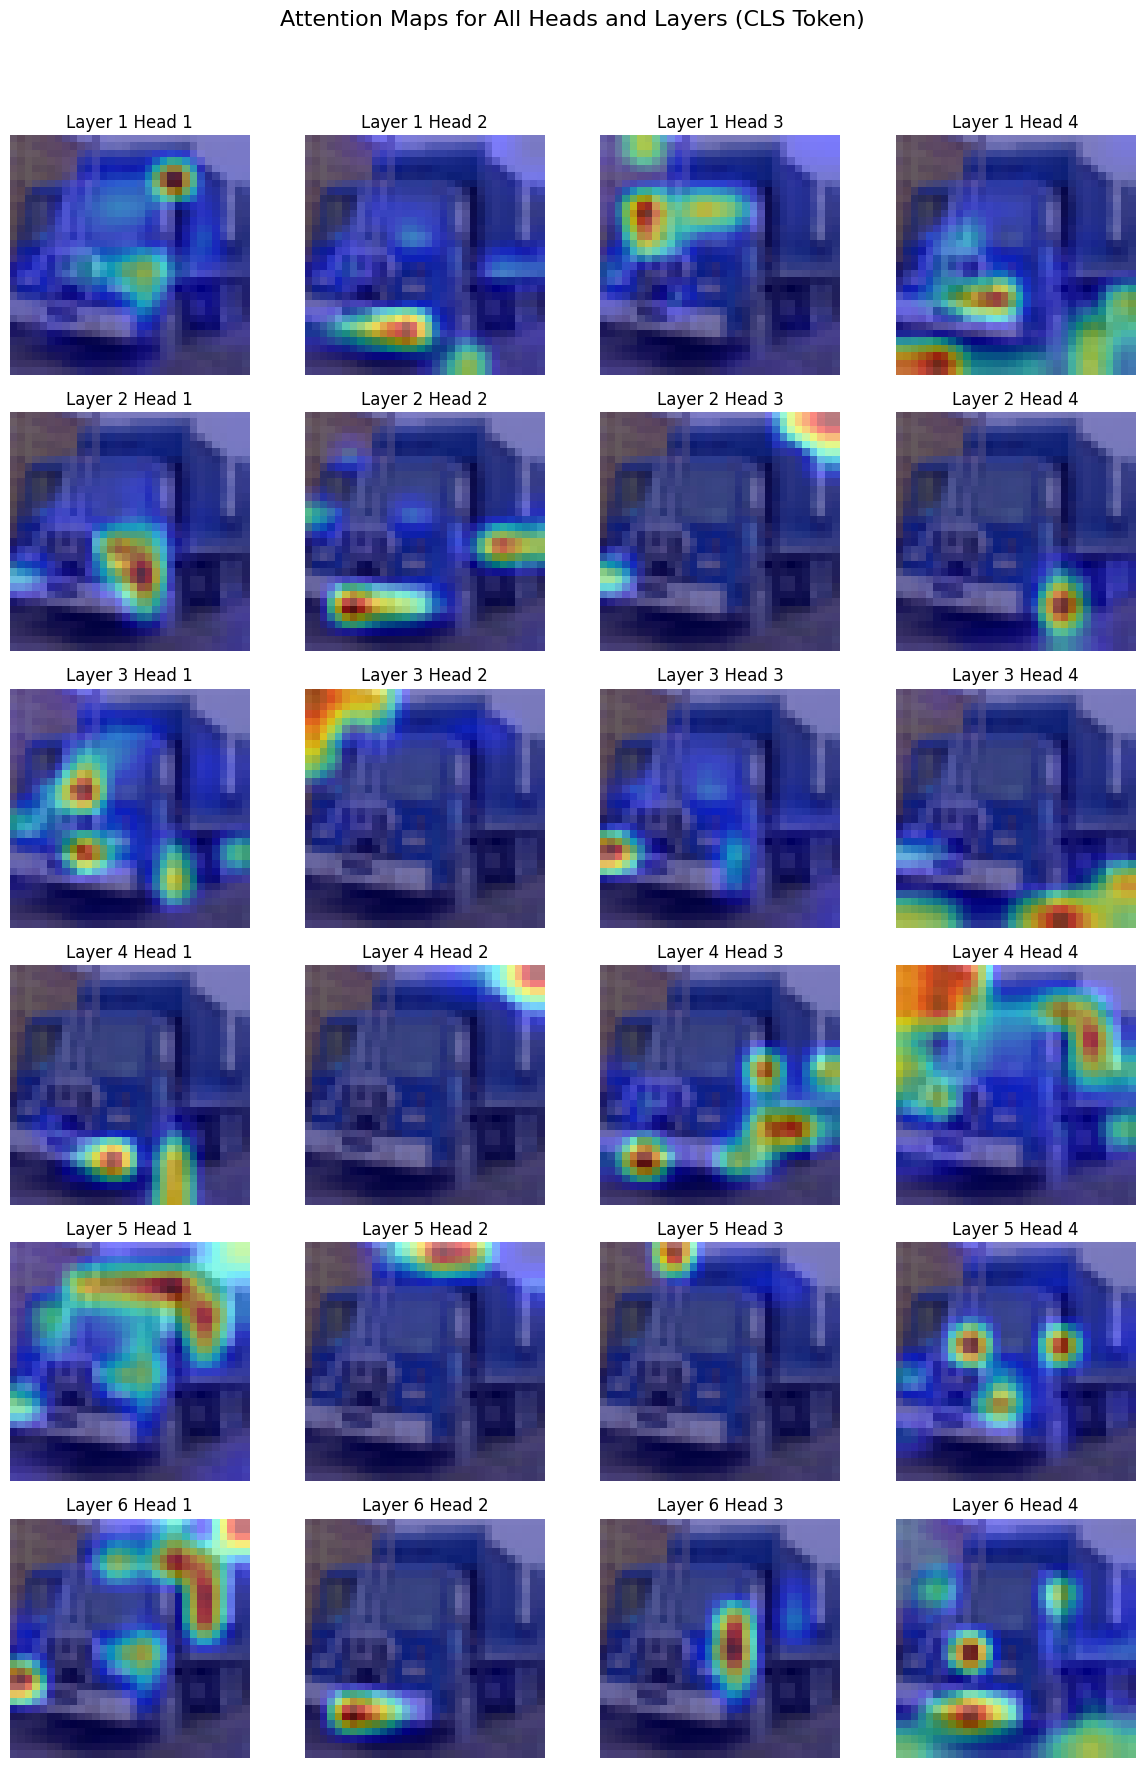

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

def get_attention_maps_all_heads(model, image_tensor):
    """
    image_tensor: (1, C, H, W)
    Returns: A list (per layer) of lists (per head) of attention maps.
    Each attention map corresponds to the CLS token's attention to all patches (excluding the CLS self-attention).
    """
    model.eval()
    all_attn_maps = []
    with torch.no_grad():
        # Obtain logits and attention maps from the model. 
        # Each element in attn_maps is of shape (B, num_heads, N, N) where N = 1 + num_patches.
        _, attn_maps = model(image_tensor, return_attn=True)
    
    for attn in attn_maps:
        # attn has shape (B, num_heads, N, N). We take batch index 0.
        layer_maps = []
        num_heads = attn.shape[1]
        for head in range(num_heads):
            # Extract attention for CLS token (index 0) to all patch tokens (indices 1:).
            attn_head = attn[0, head, 0, 1:]
            layer_maps.append(attn_head.cpu().numpy())
        all_attn_maps.append(layer_maps)
    return all_attn_maps

def plot_attention_on_axis(ax, image, attn_map, patch_size, stride, title=""):
    """
    Overlays an attention map on the given axis.
    - ax: matplotlib axis.
    - image: (H, W, 3) numpy array (original image).
    - attn_map: 1D attention weights (one value per patch).
    - patch_size, stride: used to compute grid dimensions.
    """
    H, W, _ = image.shape
    # Compute grid dimensions from patch extraction parameters.
    grid_rows = (H - patch_size) // stride + 1
    grid_cols = (W - patch_size) // stride + 1
    attn_grid = attn_map.reshape((grid_rows, grid_cols))
    # Clip values and resize to match the image dimensions.
    attn_grid = np.clip(attn_grid, 0, 1)
    attn_resized = cv2.resize(attn_grid, (W, H))
    
    ax.imshow(image)
    ax.imshow(attn_resized, cmap='jet', alpha=0.5)
    ax.axis('off')
    ax.set_title(title)


# Prepare image tensor (add batch dimension) and convert original image to numpy array.
image_tensor = img.unsqueeze(0).to(device)
image_np = img.permute(1, 2, 0).cpu().numpy()

# Get attention maps for all layers and all heads
all_attn_maps = get_attention_maps_all_heads(model_exp1, image_tensor)
# all_attn_maps is a list of length = num_layers (expected 6),
# each element is a list of attention maps for each head (expected 4 per layer).

num_layers = len(all_attn_maps)       # Expected: 6
num_heads = len(all_attn_maps[0])      # Expected: 4

# Create a figure with a grid of subplots: rows = num_layers, cols = num_heads
fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads*3, num_layers*3))

for layer_idx, layer_maps in enumerate(all_attn_maps):
    for head_idx, attn_map in enumerate(layer_maps):
        ax = axes[layer_idx, head_idx] if num_layers > 1 else axes[head_idx]
        title = f"Layer {layer_idx+1} Head {head_idx+1}"
        plot_attention_on_axis(ax, image_np, attn_map, patch_size=4, stride=4, title=title)

fig.suptitle("Attention Maps for All Heads and Layers (CLS Token)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
